In [1]:
#@title **Imports**
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from tqdm import tqdm
import random
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import pairwise_distances
from mpl_toolkits.axes_grid1 import make_axes_locatable
from itertools import product as cartesian_prod
#save numpy array as npz file
from numpy import asarray
from numpy import savez_compressed
# load numpy array from npz file
from numpy import load
from operator import itemgetter
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**Variable parameters**

In [2]:
num_train_data=3000
num_vali_data=3000
num_test_data=3000
dim=2 #no of dimension x=(x1,x2)
num_modes=2*dim # used in the 4 mode classification problem

model_type = "Regression" #"Classification" #for four mode classification data use Classification and for square decision tree data use Regression
seed=0
num_hidden_layers=3
input_dim=dim
output_dim=1
num_hidden_nodes=[5,5,5] #hidden nodes for each layer
beta=[100,10000] #When freeze is true then the layer corr to unfreezed node beta value is beta[0]=100 or 20, rest beta is beta[1]=10k, for freeze false every layer beta is beta[0].
no_of_batches=1 #[1,10,100]
modep='pwc' #piece wise constant means all 1's will be given as input to DLGN NPV.
num_epoch=5000
lr=0.0001
weight_decay=0.0

test_on_train_data = False #Default False, set True to generate node hyperplanes images on training data

freeze = False #True - when freeze weights of all nodes except one. False- when all nodes weights are varying
layer_num = 3 #Layer number whose node is only varying and rest are freezed
node_num = 3 #Node number of the above layer which is only varying rest are freeze


NPF_freeze = False #Default False, set True - to freeze the whole NPF
NPV_freeze = False #Default False, set True - to freeze the whole NPV
NPF_pretrained_freezed = False #Default False, set True - to freeze the whole NPF after training it to max and NPV is trained from reinit
NPV_pretrained_freezed = False #Default False, set True - to freeze the whole NPV after training it to max and NPF is trained from reinit


train_model = False #Set to true if training a model and False if only infer a trained model
infer_model = True #Set to true if infer a pretrained model or infer along with training


show_all_epoch_node_hyperplane = False #Set to true if wants to show and store all node hyperplanes of all epochs
best_epoch_show = False #Set to true if wants to show the node hyperplanes of the best epoch
save_img = False

file_path = "/content/drive/MyDrive/Research/Saved_models/"
# file_name_load = file_path+"R_NPF_pretrained_Fixed_1L_3L5N_Beta_20_seed_365.npz" #change the model name to infer a pretrained model
file_name_load = file_path+"R_NPF_Fixed_1L_3L5N_Beta_100_seed_0.npz" #change the model name to infer a pretrained model
# file_name_load = file_path+"R_NPF_pretrained_Fixed_1L_3L5N_Beta_100_seed_0.npz" #change the model name to infer a pretrained DLGN model

# file_name_load_lr = file_path +"Path_LR_model_NPF_pretrained.npz"
file_name_load_lr = file_path +"Path_LR_model_NPF_Fixed_Beta_100_sigmoid.npz"
# file_name_load_lr = file_path +"Path_LR_model_NPF_pretrained_Beta_100_weinit_0_sigmoid.npz" #change the model name to infer a pretrained Linear Regression model or to store the model with this name

enter_path = (0,1,2) #enter the path whose path_value is to be determined in list form as (1st_layer_node_num,2nd_layer_node_num,3rd_layer_node_num)
enter_epoch = 0 #enter the epoch no (perfect sq number) whose node hyperplane is to be visualised
plot_epoch = 5000 #epoch till which we want to plot
lr_path = 0.01 #learning rate for the LR model


Path_LR_hypPlane = False #True-- Calculate Path_LR model using hyper plane method, False--> calculating using sigmoid method
train_lr = False #Train the LR model
infer_path_lr = True #Infer the LR model

train_dlgn_lr = True #Train the hybrid DLGN_LR model (DLGN_LR_FC)
infer_dlgn_lr = True #Infer the hybrid DLGN_LR model (DLGN_LR_FC)
file_name_load_dlgnlr= "dlgn_lr_model.npz"

max_no_of_nodes=max(num_hidden_nodes) #max of all the no of nodes in all layers

In [3]:
#@title **Synthetic data**
def set_npseed(seed):
  np.random.seed(seed)
  random.seed(seed)

def set_torchseed(seed):
  torch.manual_seed(seed)
  torch.cuda.manual_seed(seed)
  torch.cuda.manual_seed_all(seed)
  torch.backends.cudnn.deterministic = True
  torch.backends.cudnn.benchmark = False
  
#Four mode classification data (synthetic dataset-1)
def data_gen1(num_train_data,num_vali_data,num_test_data,dim=2,seed=0):
  set_npseed(seed = seed)
  d=dim
  num_modes=2*d
  centers = np.concatenate((np.eye(d), -1*np.eye(d)), axis=0)
  np.random.shuffle(centers)
  hard=num_modes//2 #half are hard modes means having multi label data, easy modes have only one label

  a=[4]* hard + [1]*(num_modes - hard)
  mode_frac = np.array([1./num_modes]*num_modes)
  b=1.
  num_train_data = num_train_data 
  num_vali_data=num_vali_data
  num_test_data=num_test_data
  num_data = num_train_data + num_vali_data + num_test_data

  num_data_per_mode = np.int32(num_data*mode_frac)
  num_data_per_mode = np.concatenate((num_data_per_mode,[np.sum(num_data_per_mode)]))

  landmarks=[-1]*num_modes
  labels=[-1]*num_modes
  for i in range(num_modes):
    landmarks[i] = 0.05*np.random.randn(a[i],d)
    landmarks[i]+=centers[i]
    labels[i] = (i - np.arange(len(landmarks[i])))%2
      
  data=[-1]*num_modes
  data_labels=[-1]*num_modes

  train_data=[-1]*num_modes
  train_data_labels=[-1]*num_modes

  test_data=[-1]*num_modes
  test_data_labels=[-1]*num_modes

  vali_data=[-1]*num_modes
  vali_data_labels=[-1]*num_modes


  modes_data=[]

  for i in range(num_modes):
    data[i] = 0.1*np.random.randn(num_data_per_mode[i],d)
    data[i] += centers[i]
    data_labels[i] = np.zeros(num_data_per_mode[i])
    for j in range(len(data_labels[i])):
      dists = pairwise_distances(data[i][j:j+1,:],landmarks[i])                                   
      j_star = np.argmin(dists[0])
      data_labels[i][j]=labels[i][j_star]
      
      train_data[i] = np.array(data[i][:int(mode_frac[i]*num_train_data)])
      train_data_labels[i] = np.array(data_labels[i][:int(mode_frac[i]*num_train_data)])

      vali_data[i] = np.array(data[i][int(mode_frac[i]*num_train_data): \
                                      int(mode_frac[i]*num_train_data)+int(mode_frac[i]*num_vali_data)])
      vali_data_labels[i] = np.array(data_labels[i][int(mode_frac[i]*num_train_data): \
                                      int(mode_frac[i]*num_train_data)+int(mode_frac[i]*num_vali_data)])

      test_data[i] = np.array(data[i][-int(mode_frac[i]*num_test_data):])
      test_data_labels[i] = np.array(data_labels[i][-int(mode_frac[i]*num_test_data):])
      
  return data,data_labels,train_data,train_data_labels,test_data,test_data_labels,vali_data,vali_data_labels,landmarks,labels,centers,mode_frac

def uniform_data_gen(num_data,dim=2): #used by data_gen2 function for uniform data generations
  n=num_data
  d=dim
  x0x1_min = [-1.0, -1.0]
  x0x1_max = [1.0, 1.0]
  data = np.random.uniform(low=x0x1_min, high=x0x1_max, size=(n,d))
  y=np.zeros(n,dtype=np.float32)
  for i,val in enumerate(data):
    if(-1<=val[0]<=0 and 0<=val[1]<=1):
      y[i]=1
    elif (0<=val[0]<=1 and 0.5<=val[1]<=1):
      y[i]=0.2
    elif(0<=val[0]<=1 and -0.5<=val[1]<=0.5):
      y[i]=0.5
    else:
      y[i]=-1
  return data,y

#Square decision tree data
def data_gen2(num_train_data,num_vali_data,num_test_data,dim=2,seed=0): #using the above uniform_data_gen junction to generate train,test,valid data seperately
  set_npseed(seed = seed)
  train_data,train_data_labels=uniform_data_gen(num_train_data,dim=dim)
  vali_data,vali_data_labels=uniform_data_gen(num_vali_data,dim=dim)
  test_data,test_data_labels=uniform_data_gen(num_test_data,dim=dim)
  data = np.concatenate((train_data,vali_data),axis=0)
  data = np.concatenate((data,test_data),axis=0)
  data_labels = np.concatenate((train_data_labels,vali_data_labels),axis=0)
  data_labels = np.concatenate((data_labels,test_data_labels),axis=0)
  return data,data_labels,train_data,train_data_labels,test_data,test_data_labels,vali_data,vali_data_labels,None,None,None,None #last 4 entries are kept None to match the data_gen1 return format

In [4]:
#@title **DLGN_FC**
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using {} device".format(device))

class DLGN_FC(nn.Module):
  def __init__(self, to_copy=None,NPF_pretrained=True,NPV_pretrained=True, num_hidden_layers=0, input_dim=2, output_dim=1, num_hidden_nodes=[], beta=20, mode='pwc'):
    super(DLGN_FC, self).__init__()
    if to_copy==None:
      self.gating_layers=[]
      self.value_layers=[]
      self.num_hidden_layers = num_hidden_layers
      self.beta=beta  # Soft gating parameter
      self.mode = mode
      self.num_nodes=[input_dim]+num_hidden_nodes+[output_dim]
      for i in range(num_hidden_layers+1):
        self.gating_layers.append(nn.Linear(self.num_nodes[i], self.num_nodes[i+1]))
        self.value_layers.append(nn.Linear(self.num_nodes[i], self.num_nodes[i+1], bias=False))
    else: #to_copy is used for using parameters from other DLGN epoch (basically to stored DLGN models)
      self.gating_layers=[]
      self.value_layers=[]
      self.num_hidden_layers = to_copy.num_hidden_layers
      self.beta=to_copy.beta  # Soft gating parameter
      self.mode = to_copy.mode
      self.num_nodes=list(to_copy.num_nodes)
      for i in range(self.num_hidden_layers+1):
        self.gating_layers.append(nn.Linear(self.num_nodes[i], self.num_nodes[i+1]))
        self.value_layers.append(nn.Linear(self.num_nodes[i], self.num_nodes[i+1], bias=False))
        if NPF_pretrained: #by default True, False-- don't store the gating layer parameters, set to reinit
          self.gating_layers[i].weight.data =  torch.Tensor(np.array(to_copy.gating_layers[i].weight.detach().numpy()))
          self.gating_layers[i].bias.data = torch.Tensor(np.array(to_copy.gating_layers[i].bias.detach().numpy()))
        if NPV_pretrained: #by default True, False-- don't store the value layer parameters, set to reinit
          self.value_layers[i].weight.data = torch.Tensor(np.array(to_copy.value_layers[i].weight.detach().numpy()))

                
  def return_gating_functions(self): #helps in returning the effective_weights, effective_biases for each node of each layer
    effective_weights = []
    effective_biases =[]
    for i in range(self.num_hidden_layers):
      curr_weight = self.gating_layers[i].weight
      curr_bias = self.gating_layers[i].bias
      if i==0:
        effective_weights.append(curr_weight)
        effective_biases.append(curr_bias)
      else:
        effective_biases.append(torch.matmul(curr_weight,effective_biases[-1])+curr_bias) #since the gating network is linear effective w for layer 2 will be prod of w and b of layer 1 and 2
        effective_weights.append(torch.matmul(curr_weight,effective_weights[-1]))
    return effective_weights, effective_biases
    # effective_weights (and effective biases) is a list of size num_hidden_layers
              

  def forward(self, x):
    gate_scores=[x]
    if self.mode=='pwc':
      values=[torch.ones(x.shape)]
    else:
      values=[x]
    
    for i in range(self.num_hidden_layers):
      beta_used = beta[0]
      if ((i!=layer_num-1) and freeze): #if freeze is True beta_used is beta[1]
        beta_used = beta[1]
      gate_scores.append(self.gating_layers[i](gate_scores[-1]))
      curr_gate_on_off = torch.sigmoid(beta_used*gate_scores[-1]) #calculating the gate musking used for value layer
      values.append(self.value_layers[i](values[-1])*curr_gate_on_off)
    values.append(self.value_layers[self.num_hidden_layers](values[-1]))
    # Values is a list of size 1+num_hidden_layers+1
    #gate_scores is a list of size 1+num_hidden_layers
    return values,gate_scores

Using cpu device


In [5]:
class DLGN_LR_FC(nn.Module): #Hybrid model with Gating network same as NPF whose gates are used in LR network instead of NPV to find 5x5x5 paths, to apply linear regression on them
  def __init__(self, to_copy=None,num_path_features=125, num_hidden_layers=0, input_dim=2, output_dim=1, num_hidden_nodes=[], beta=20):
    super(DLGN_LR_FC, self).__init__()
    if to_copy==None:
      self.gating_layers=[]
      self.path_layer=[] #Path n/w or LR n/w takes in 5x5x5 paths (on-off status) as input features to a LinearReg model and predicts the output
      self.num_hidden_layers = num_hidden_layers
      self.beta=beta  # Soft gating parameter
      self.num_nodes=[input_dim]+num_hidden_nodes+[output_dim]
      for i in range(num_hidden_layers+1):
        self.gating_layers.append(nn.Linear(self.num_nodes[i], self.num_nodes[i+1]))

      self.path_layer.append(nn.Linear(num_path_features, output_dim, bias=False))
      self.path_layer[0].weight.data.fill_(0.0) #initializing weights of the path layer to 0

    else:

      self.gating_layers=[]
      self.num_hidden_layers = to_copy.num_hidden_layers
      self.beta=to_copy.beta  # Soft gating parameter
      self.num_nodes=list(to_copy.num_nodes)
      for i in range(self.num_hidden_layers+1):
        self.gating_layers.append(nn.Linear(self.num_nodes[i], self.num_nodes[i+1]))
        self.gating_layers[i].weight.data =  torch.Tensor(np.array(to_copy.gating_layers[i].weight.detach().numpy()))
        self.gating_layers[i].bias.data = torch.Tensor(np.array(to_copy.gating_layers[i].bias.detach().numpy()))
      self.path_layer=[]
      self.path_layer.append(nn.Linear(num_path_features, output_dim, bias=False))
      self.path_layer[0].weight.data = torch.Tensor(np.array(to_copy.path_layer[0].weight.detach().numpy()))
                

  def return_gating_functions(self):
    effective_weights = []
    effective_biases =[]
    for i in range(self.num_hidden_layers):
      curr_weight = self.gating_layers[i].weight
      curr_bias = self.gating_layers[i].bias
      if i==0:
        effective_weights.append(curr_weight)
        effective_biases.append(curr_bias)
      else:
        effective_biases.append(torch.matmul(curr_weight,effective_biases[-1])+curr_bias)
        effective_weights.append(torch.matmul(curr_weight,effective_weights[-1]))
    return effective_weights, effective_biases
    # effective_weights (and effective biases) is a list of size num_hidden_layers
              
  def forward(self, x):
    gate_scores=[x]
    values=[]
    for i in range(self.num_hidden_layers):
      beta_used = beta[0]
      gate_scores.append(self.gating_layers[i](gate_scores[-1]))
      curr_gate_on_off = torch.sigmoid(beta_used*gate_scores[-1]) #gate values from gating layers
      values.append(curr_gate_on_off) #values[0], values[1],values[2] --> 3000x5 (num_data x num_nodes_per_layer) gating_on_off values
    values = torch.stack(values,dim=1) #(3000,3,5), values[0] --> values[:,0,:] (dim 3000x5), values[1]-->values[:,1,:] and values[2]-->values[:,2,:]

    #a=values[:,0,:].unsqueeze(dim=2) --> (3000x5x1) and b=values[:,1,:].unsqueeze(dim=1) --> (3000x1x5)
    #a*b --> (3000x5x5), a*b.view(3000,-1)--> (3000,25)
    '''
    a = torch.tensor([[1,2,3],[4,5,6]])
    b = torch.tensor([[10,100,1000],[1,2,3]])
    (a.unsqueeze(dim=2)*b.unsqueeze(dim=1))
    tensor([[[  10,  100, 1000],
         [  20,  200, 2000],
         [  30,  300, 3000]],

        [[   4,    8,   12],
         [   5,   10,   15],
         [   6,   12,   18]]])

    (a.unsqueeze(dim=2)*b.unsqueeze(dim=1)).view(2,-1)
    tensor([[  10,  100, 1000,   20,  200, 2000,   30,  300, 3000],
        [   4,    8,   12,    5,   10,   15,    6,   12,   18]])
    '''

    values1 = (values[:,0,:].unsqueeze(dim=2)*values[:,1,:].unsqueeze(dim=1)).view(values.shape[0],-1) #(3000,25) 
    values2 = (values1.unsqueeze(dim=2)*values[:,2,:].unsqueeze(dim=1)).view(values.shape[0],-1) #(3000,125)

    path_values=self.path_layer[0](values2) #(3000x125)-->(3000x1)

    return path_values,gate_scores

In [6]:
#@title **Path_LR**
class Path_LR(nn.Module): #Linear Regression with 5x5x5 path on_off status as input and finding the weights of the paths
  def __init__(self, to_copy=None,num_path_features=125, output_dim=1):
    super(Path_LR, self).__init__()
    if to_copy==None:
      self.path_layer=[]
      self.path_layer.append(nn.Linear(num_path_features, output_dim, bias=False))
      self.path_layer[0].weight.data.fill_(0.0)
    else:
      self.path_layer=[]
      self.path_layer.append(nn.Linear(num_path_features, output_dim, bias=False))
      self.path_layer[0].weight.data = torch.Tensor(np.array(to_copy.path_layer[0].weight.detach().numpy()))

  def forward(self, x):
    path_values=self.path_layer[0](x)
    return path_values

In [7]:
#@title **Check perfect sq**
def perfectSq(N) :
	sq_root = round(N**(1/2));
	if sq_root * sq_root == N :
		return True;
	else :
		return False;

In [8]:
#@title **Train DLGN model**
if train_model:
  def train_dlgn(seed,num_hidden_layers,input_dim,output_dim,num_hidden_nodes,beta,no_of_batches,
                mode,layer_num,node_num,train_data_curr,vali_data_curr,test_data_curr,train_labels_curr,test_labels_curr,vali_labels_curr,num_epoch,freeze,DLGN_obj_pretrained=None,NPF_pretrained = True,NPV_pretrained = True):
    
    layer_num=layer_num-1 #layer no of node to unfreeze
    node_num=node_num-1 #node no of above layer to unfreeze when freeze is True

    set_torchseed(seed)

    if freeze:
      DLGN_obj_initial = None
    DLGN_obj = None
    DLGN_obj_return = None
    if DLGN_obj_pretrained == None:
      DLGN_obj = DLGN_FC(num_hidden_layers=num_hidden_layers, input_dim=input_dim, output_dim=output_dim, 
                        num_hidden_nodes=num_hidden_nodes, beta=beta, mode=mode)
    else: # using DLGN_obj_pretrained as already pre trained model received as argument
      DLGN_obj = DLGN_FC(to_copy=DLGN_obj_pretrained,NPF_pretrained=NPF_pretrained,NPV_pretrained=NPV_pretrained)

    if freeze:
      DLGN_obj_initial = DLGN_FC(to_copy=DLGN_obj)
    
    DLGN_obj_return = DLGN_FC(to_copy=DLGN_obj)

    if model_type == "Classification":
      criterion = nn.CrossEntropyLoss()
    if model_type == "Regression":
      criterion = nn.MSELoss()
    
    

    DLGN_params = []
    DLGN_params += [item.weight for item in DLGN_obj.gating_layers]
    DLGN_params += [item.bias for item in DLGN_obj.gating_layers]
    DLGN_params += [item.weight for item in DLGN_obj.value_layers]
  #     DLGN_params += [item.bias for item in DLGN_obj.value_layers]

    if NPF_freeze: #set requires_grad=False for NPF params
      for index,param in enumerate(DLGN_params):
        if(index<2*len(DLGN_obj.gating_layers)):
          param.requires_grad=False
    if NPV_freeze: #set requires_grad=False for NPV params
      for index,param in enumerate(DLGN_params):
        if(index>=2*len(DLGN_obj.gating_layers)):
          param.requires_grad=False
    if freeze: #set requires_grad=True for only that layer containing the node rest all grads are False
      for index,param in enumerate(DLGN_params):
        if((index != layer_num)):
          param.requires_grad=False
        if((index==len(DLGN_obj.gating_layers)+layer_num)):
          param.requires_grad=True


    optimizer = optim.Adam(DLGN_params, lr=lr, weight_decay=weight_decay)
    
    
    train_data_torch = torch.Tensor(train_data_curr)
    vali_data_torch = torch.Tensor(vali_data_curr)
    test_data_torch = torch.Tensor(test_data_curr)

    if model_type == "Classification":
      train_labels_torch = torch.tensor(train_labels_curr, dtype=torch.int64)
      test_labels_torch = torch.tensor(test_labels_curr, dtype=torch.int64)
      vali_labels_torch = torch.tensor(vali_labels_curr, dtype=torch.int64)
    if model_type == "Regression":
      train_labels_torch = torch.tensor(train_labels_curr)
      test_labels_torch = torch.tensor(test_labels_curr)
      vali_labels_torch = torch.tensor(vali_labels_curr)

    num_batches = no_of_batches
    batch_size = len(train_data_curr)//num_batches
    losses=[]
    DLGN_obj_store = []
    best_vali_error = len(vali_labels_curr)


    for epoch in tqdm(range(num_epoch)):  # loop over the dataset multiple times
      running_loss = 0.0
      if perfectSq(epoch): #storing DLGN params for all squared no epochs
        DLGN_obj_store.append(DLGN_FC(to_copy=DLGN_obj))
      
      for batch_start in range(0,len(train_data_curr),batch_size):
        optimizer.zero_grad()
        values,gate_scores = DLGN_obj(train_data_torch[batch_start:batch_start+batch_size])
        
        if model_type == "Classification":
          outputs = torch.cat((-1*values[-1], values[-1]), dim=1)
          loss = criterion(outputs, train_labels_torch[batch_start:batch_start+batch_size])
        if model_type == "Regression":
          outputs = values[-1]
          loss = criterion(outputs, train_labels_torch[batch_start:batch_start+batch_size].reshape(outputs.shape))

        loss.backward()
        optimizer.step()

        if freeze:
          for node in range(num_hidden_nodes[layer_num]):
            if(node!=node_num): #setting all node weights to initial node weights except the node to unfreeze thus freezing all nodes except one
              DLGN_params[layer_num].data[node]= DLGN_obj_initial.gating_layers[layer_num].weight.data[node]
              DLGN_params[len(DLGN_obj.gating_layers)+layer_num].data[node]= DLGN_obj_initial.gating_layers[layer_num].bias.data[node]


        running_loss += loss.item()    
      losses.append(running_loss/num_batches)

      #validation data
      values,gate_scores =DLGN_obj(vali_data_torch)
      if model_type == "Classification":
        vali_preds = torch.cat((-1*values[-1], values[-1]), dim=1)
        vali_preds = torch.argmax(vali_preds, dim=1).numpy()
        vali_error= np.sum(vali_labels_torch.numpy()!=vali_preds)
      if model_type == "Regression":
        vali_preds = values[-1]
        vali_error = criterion(vali_preds, vali_labels_torch.reshape(vali_preds.shape)).item()
        vali_preds = vali_preds.detach().numpy()
      if vali_error < best_vali_error:
        DLGN_obj_return = DLGN_FC(to_copy=DLGN_obj)
        best_vali_error = vali_error
    
    #test data
    values,gate_scores =DLGN_obj_return(test_data_torch)
    if model_type == "Classification":
      test_preds = torch.cat((-1*values[-1], values[-1]), dim=1)
      test_preds = torch.argmax(test_preds, dim=1).numpy()
      test_error= np.sum(test_labels_torch.numpy()!=test_preds)
    if model_type == "Regression":
      test_preds = values[-1]
      test_error = criterion(test_preds, test_labels_torch.reshape(test_preds.shape)).item()
      test_preds = test_preds.detach().numpy()

    #train data
    values,gate_scores=DLGN_obj_return(train_data_torch)
    if model_type == "Classification":
      train_preds = torch.cat((-1*values[-1], values[-1]), dim=1)
      train_preds = torch.argmax(train_preds, dim=1).numpy()
      train_error= np.sum(train_labels_torch.numpy()!=train_preds)
    if model_type == "Regression":
      train_preds = values[-1]
      train_error = criterion(train_preds, train_labels_torch.reshape(train_preds.shape)).item()
      train_preds = train_preds.detach().numpy()

    plt.figure()
    plt.title("DLGN loss vs epoch")
    plt.plot(losses)
    return losses,test_error, train_error, test_preds, DLGN_obj_return, DLGN_obj_store

In [9]:
#@title **Train DLGN_LR model**
#Training the hybrid DLGN_LR_FC model
if train_dlgn_lr:
  def train_dlgn_lr(seed,num_path_features,num_hidden_layers,input_dim,output_dim,num_hidden_nodes):
    set_torchseed(seed)
    DLGN_LR_obj = None
    DLGN_LR_return = None 
    DLGN_LR_obj = DLGN_LR_FC(num_path_features=num_path_features,num_hidden_layers=num_hidden_layers, input_dim=input_dim, output_dim=output_dim, 
                        num_hidden_nodes=num_hidden_nodes,beta=beta)
    

    DLGN_LR_return = DLGN_LR_FC(to_copy=DLGN_LR_obj)

    if model_type == "Classification":
      criterion = nn.CrossEntropyLoss()
    if model_type == "Regression":
      criterion = nn.MSELoss()


    DLGN_LR_params = []
    DLGN_LR_params += [item.weight for item in DLGN_LR_obj.gating_layers]
    DLGN_LR_params += [item.bias for item in DLGN_LR_obj.gating_layers]
    DLGN_LR_params += [item.weight for item in DLGN_LR_obj.path_layer]


    optimizer = optim.Adam(DLGN_LR_params, lr=lr_path, weight_decay=weight_decay)


    train_data_torch = torch.Tensor(train_data_curr)
    vali_data_torch = torch.Tensor(vali_data_curr)
    test_data_torch = torch.Tensor(test_data_curr)


    if model_type == "Classification":
      train_labels_torch = torch.tensor(train_labels_curr, dtype=torch.int64)
      test_labels_torch = torch.tensor(test_labels_curr, dtype=torch.int64)
      vali_labels_torch = torch.tensor(vali_labels_curr, dtype=torch.int64)
    if model_type == "Regression":
      train_labels_torch = torch.tensor(train_labels_curr)
      test_labels_torch = torch.tensor(test_labels_curr)
      vali_labels_torch = torch.tensor(vali_labels_curr)



    num_batches = no_of_batches
    batch_size = len(train_data_curr)//num_batches
    losses=[]
    DLGN_LR_obj_store = []
    best_vali_error = len(vali_labels_curr)


    for epoch in tqdm(range(num_epoch)):  # loop over the dataset multiple times
      running_loss = 0.0
      if perfectSq(epoch):
        DLGN_LR_obj_store.append(DLGN_LR_FC(to_copy=DLGN_LR_obj))
      
      for batch_start in range(0,len(train_data_curr),batch_size):
        optimizer.zero_grad()
        path_values,_ = DLGN_LR_obj(train_data_torch[batch_start:batch_start+batch_size])
        if model_type == "Classification":
          outputs = torch.cat((-1*path_values, path_values), dim=1)
          loss = criterion(outputs, train_labels_torch[batch_start:batch_start+batch_size])
        if model_type == "Regression":
          outputs = path_values
          loss = criterion(outputs, train_labels_torch[batch_start:batch_start+batch_size].reshape(outputs.shape))
        
        loss.backward()
        optimizer.step()

        running_loss += loss.item()    
      losses.append(running_loss/num_batches)

      path_values,_ =DLGN_LR_obj(vali_data_torch)
      if model_type == "Classification":
        vali_preds = torch.cat((-1*path_values, path_values), dim=1)
        vali_preds = torch.argmax(vali_preds, dim=1).numpy()
        vali_error= np.sum(vali_labels_torch.numpy()!=vali_preds)
      if model_type == "Regression":
        vali_preds = path_values
        vali_error = criterion(vali_preds, vali_labels_torch.reshape(vali_preds.shape)).item()
        vali_preds = vali_preds.detach().numpy()
      if vali_error < best_vali_error:
        DLGN_LR_return = DLGN_LR_FC(to_copy=DLGN_LR_obj)
        best_vali_error = vali_error
      
    path_values,_ =DLGN_LR_return(test_data_torch)
    if model_type == "Classification":
      test_preds = torch.cat((-1*path_values, path_values), dim=1)
      test_preds = torch.argmax(test_preds, dim=1).numpy()
      test_error= np.sum(test_labels_torch.numpy()!=test_preds)
    if model_type == "Regression":
      test_preds = path_values
      test_error = criterion(test_preds, test_labels_torch.reshape(test_preds.shape)).item()
      test_preds = test_preds.detach().numpy()

    path_values,_=DLGN_LR_return(train_data_torch)
    if model_type == "Classification":
      train_preds = torch.cat((-1*path_values, path_values), dim=1)
      train_preds = torch.argmax(train_preds, dim=1).numpy()
      train_error= np.sum(train_labels_torch.numpy()!=train_preds)
    if model_type == "Regression":
      train_preds = path_values
      train_error = criterion(train_preds, train_labels_torch.reshape(train_preds.shape)).item()
      train_preds = train_preds.detach().numpy()

    plt.figure()
    plt.title("Path_LR loss vs epoch")
    plt.plot(losses)
    return losses,test_error, train_error, test_preds, DLGN_LR_return, DLGN_LR_obj_store

In [10]:
#@title **Generating data**
if model_type == "Classification":
  data_gen = data_gen1
if model_type == "Regression":
  data_gen = data_gen2
  
data,data_labels,train_data,train_data_labels,test_data,test_data_labels,vali_data,vali_data_labels, \
landmarks,labels,centers,mode_frac= data_gen(num_train_data,num_vali_data,num_test_data,dim=2,seed=0)

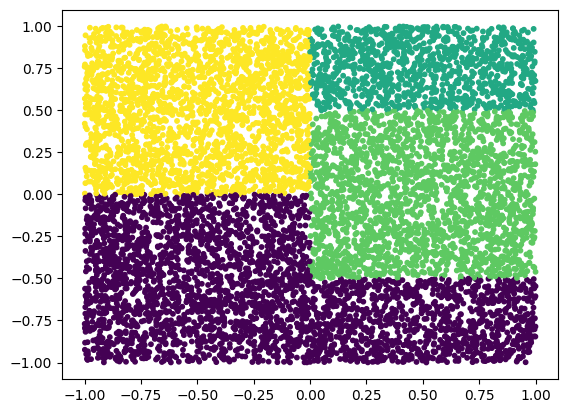

In [11]:
#@title **Plotting the data**
if model_type == "Classification":
  fig=plt.scatter(np.concatenate(data)[:,0], np.concatenate(data)[:,1], c=np.concatenate(data_labels), s=10)
if model_type == "Regression":
  fig=plt.scatter(data[:,0], data[:,1], c=data_labels, s=10)


In [12]:
#@title **Training a DLGN model**
## Convention 0th layer is input layer, 1st layer is 1st hidden layer and last layer is output layer
## so 3 hidden layers mean 1 input node + 3 hidden layers + 1 output layer

if model_type == "Classification":
  train_data_curr = np.concatenate(train_data[0:num_modes])
  train_labels_curr = np.concatenate(train_data_labels[0:num_modes])
  vali_data_curr = np.concatenate(vali_data[0:num_modes])
  vali_labels_curr = np.concatenate(vali_data_labels[0:num_modes])
  test_data_curr = np.concatenate(test_data[0:num_modes])
  test_labels_curr = np.concatenate(test_data_labels[0:num_modes]) 

if model_type == "Regression":
  train_data_curr = train_data
  train_labels_curr = train_data_labels
  vali_data_curr = vali_data
  vali_labels_curr = vali_data_labels
  test_data_curr = test_data
  test_labels_curr = test_data_labels

#training the dlgn model
if train_model:
  losses,test_error, train_error, predictions_dlgn, DLGN_obj_final, DLGN_obj_store = train_dlgn(seed,num_hidden_layers,input_dim,output_dim,num_hidden_nodes,beta,
                no_of_batches,modep,layer_num,node_num,train_data_curr,vali_data_curr,test_data_curr,train_labels_curr,test_labels_curr,vali_labels_curr,num_epoch,freeze)   

  #predictions_dlgn -- labels corresponding to the best validation model
  #DLGN_obj_final -- model corresponding to epoch with the best validation acc
  #DLGN_obj_store -- store models corresponding to epochs at regular intervals

  if NPF_pretrained_freezed: #NPF is set to pretrained model weights and freezed, NPV is set to reinit, DLGN_obj_pretrained=DLGN_obj_store[-1] using the training model last epoch defined above
    NPF_freeze = True
    losses,test_error, train_error, predictions_dlgn, DLGN_obj_final, DLGN_obj_store = train_dlgn(seed,num_hidden_layers,input_dim,output_dim,num_hidden_nodes,beta,
                no_of_batches,modep,layer_num,node_num,train_data_curr,vali_data_curr,test_data_curr,train_labels_curr,test_labels_curr,vali_labels_curr,num_epoch,freeze,DLGN_obj_pretrained=DLGN_obj_store[-1],NPF_pretrained = True,NPV_pretrained = False)   
    NPF_freeze = False #Again set it back to false

  if NPV_pretrained_freezed:
    NPV_freeze = True
    losses,test_error, train_error, predictions_dlgn, DLGN_obj_final, DLGN_obj_store = train_dlgn(seed,num_hidden_layers,input_dim,output_dim,num_hidden_nodes,beta,
                no_of_batches,modep,layer_num,node_num,train_data_curr,vali_data_curr,test_data_curr,train_labels_curr,test_labels_curr,vali_labels_curr,num_epoch,freeze,DLGN_obj_pretrained=DLGN_obj_store[-1],NPF_pretrained = False,NPV_pretrained = True)   
    NPV_freeze = False

100%|██████████| 5000/5000 [02:15<00:00, 36.91it/s]


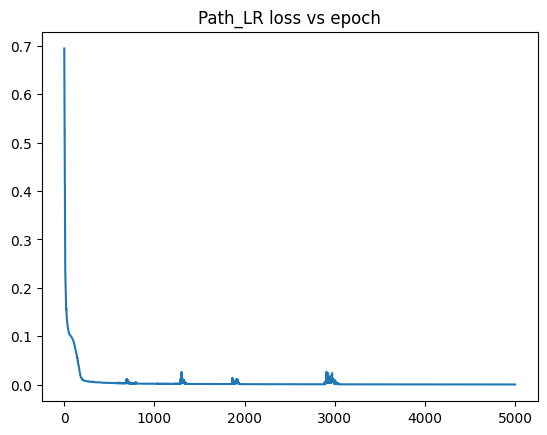

In [13]:
#Training DLGN_LR_FC
if train_dlgn_lr:
  num_path_features=np.prod(num_hidden_nodes) #5x5x5
  losses,test_error, train_error, predictions_dlgn_lr, DLGN_LR_obj_final, DLGN_LR_obj_store = train_dlgn_lr(seed,num_path_features,num_hidden_layers,input_dim,output_dim,num_hidden_nodes)   
  file_name = "dlgn_lr_model" #set DLGN_LR model name
  file_name=file_path+file_name
  savez_compressed(file_name, losses,test_error, train_error, predictions_dlgn_lr, DLGN_LR_obj_final, DLGN_LR_obj_store)
  file_name_load_dlgnlr = file_name+".npz"

In [14]:
#@title **Storing the trained output**
#Naming of the DLGN model and storing it
if train_model:
  Beta_str = "Beta_"+str(beta[0])+"_"
  if model_type == "Regression":
    a="R_"
  if model_type == "Classification":
    a="C_"
  if freeze:
    prefix = "Layer_"+str(layer_num)+"_node_"+str(node_num)+"_"
    Beta_str = "Beta_"+str(beta[0])+"_"+str(int(beta[1]/1000))+"k_"
  elif NPF_freeze:
    prefix = "NPF_Fixed_"
  elif NPV_freeze:
    prefix = "NPV_Fixed_"
  elif NPF_pretrained_freezed:
    prefix = "NPF_pretrained_Fixed_"
  elif NPV_pretrained_freezed:
    prefix = "NPV_pretrained_Fixed_"
  else:
    prefix = "No_node_"
  epoch_str = str(int(num_epoch/100000))+"L_"
  file_name = a+prefix+epoch_str+str(num_hidden_layers)+"L"+str(max_no_of_nodes)+"N_"+Beta_str+"seed_"+str(seed)
  
  # save to npy file
  file_name=file_path+file_name
  savez_compressed(file_name, losses,test_error, train_error, predictions_dlgn, DLGN_obj_final, DLGN_obj_store)
  file_name_load = file_name+".npz"

**Infer the trained model**

test_error 0.39875656366348267
train_error 0.39569538831710815


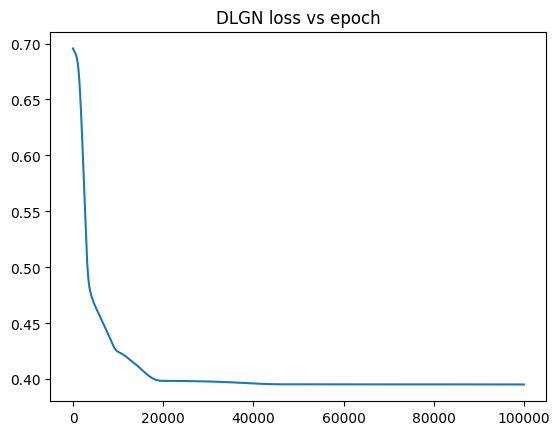

In [15]:
#@title **Load model**
if infer_model:
  # load dict of arrays
  dict_data = load(file_name_load,allow_pickle=True)
  losses=dict_data['arr_0']
  test_error=dict_data['arr_1'].item()
  train_error=dict_data['arr_2'].item()
  predictions_dlgn=dict_data['arr_3']
  DLGN_obj_final=dict_data['arr_4'].item()
  DLGN_obj_store=dict_data['arr_5']
  plt.figure()
  plt.title("DLGN loss vs epoch")
  fig=plt.plot(losses[:])
  if model_type == "Classification":
    print("test_error",test_error/len(test_data_curr))
    print("train_error",train_error/len(train_data_curr))
    print('DLGN acc=',np.sum(predictions_dlgn==test_labels_curr)/len(test_data_curr))
  if model_type == "Regression":
    print("test_error",test_error)
    print("train_error",train_error)

**Infer dlgn lr model**

test_error 0.0013511700090020895
train_error 0.001040791510604322


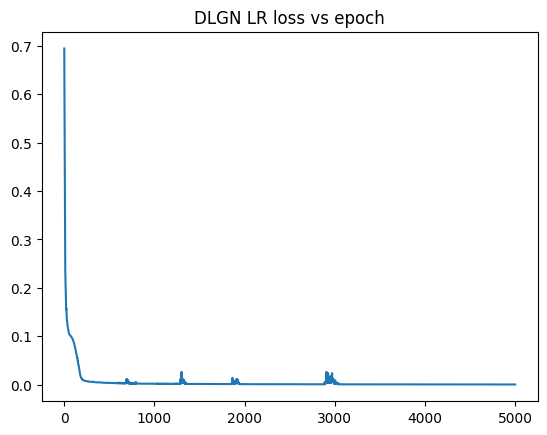

In [16]:
if infer_dlgn_lr:
  # load dict of arrays 
  dict_data_dlgnlr = load(file_name_load_dlgnlr,allow_pickle=True)
  losses_dlgnlr=dict_data_dlgnlr['arr_0']
  test_error_dlgnlr=dict_data_dlgnlr['arr_1'].item()
  train_error_dlgnlr=dict_data_dlgnlr['arr_2'].item()
  predictions_dlgn_lr=dict_data_dlgnlr['arr_3']
  DLGN_LR_obj_final=dict_data_dlgnlr['arr_4'].item()
  DLGN_LR_obj_store=dict_data_dlgnlr['arr_5']
  plt.figure()
  plt.title("DLGN LR loss vs epoch")
  fig=plt.plot(losses_dlgnlr[:])
  if model_type == "Classification":
    print("test_error",test_error_dlgnlr/len(test_data_curr))
    print("train_error",train_error_dlgnlr/len(train_data_curr))
    print('DLGN acc=',np.sum(predictions_dlgn_lr==test_labels_curr)/len(test_data_curr))
  if model_type == "Regression":
    print("test_error",test_error_dlgnlr)
    print("train_error",train_error_dlgnlr)


In [17]:
#@title **Path_LR data preparation sigmoid method**
def Path_LR_dataPrep_sigmoid(data_curr):
  DLGN_obj = DLGN_obj_store[-1]
  effective_weights, effective_biases = DLGN_obj.return_gating_functions()

  x=(data_curr@effective_weights[0].data.numpy().T)+effective_biases[0].data.numpy() #(3000x5)--> 1st layer node pre_activation
  y=(data_curr@effective_weights[1].data.numpy().T)+effective_biases[1].data.numpy() #(3000x5)--> 2nd layer node pre_activation
  z=(data_curr@effective_weights[2].data.numpy().T)+effective_biases[2].data.numpy() #(3000x5)--> 3rd layer node pre_activation

  x1=torch.sigmoid(beta[0]*torch.Tensor(x)) #(3000x5)--> 1st layer node gates
  y1=torch.sigmoid(beta[0]*torch.Tensor(y)) #(3000x5)--> 2nd layer node gates
  z1=torch.sigmoid(beta[0]*torch.Tensor(z)) #(3000x5)--> 3rd layer node gates

  xy=np.zeros((x1.shape[0],x1.shape[1]*y1.shape[1]))
  for i in range(x1.shape[0]):
    xy[i]=np.multiply.outer(x1[i], y1[i]).ravel() #(3000x25)

  xyz=np.zeros((x1.shape[0],xy.shape[1]*z1.shape[1]))
  for i in range(x1.shape[0]):
    xyz[i]=np.multiply.outer(xy[i], z1[i]).ravel() #(3000x125)

  # x=(data_curr@effective_weights[0].T)+effective_biases[0] #(3000x5)--> 1st layer node pre_activation
  # y=(data_curr@effective_weights[1].T)+effective_biases[1] #(3000x5)--> 2nd layer node pre_activation
  # z=(data_curr@effective_weights[2].T)+effective_biases[2] #(3000x5)--> 3rd layer node pre_activation

  # values = []
  # values.append(torch.sigmoid(beta[0]*x)) #(3000x5)--> 1st layer node gates
  # values.append(torch.sigmoid(beta[0]*y)) #(3000x5)--> 2nd layer node gates
  # values.append(torch.sigmoid(beta[0]*z)) #(3000x5)--> 3rd layer node gates

  # values = torch.stack(values,dim=1) #(3000x3x5)
  # values1 = (values[:,0,:].unsqueeze(dim=2)*values[:,1,:].unsqueeze(dim=1)).view(values.shape[0],-1) #(3000,25) 
  # values2 = (values1.unsqueeze(dim=2)*values[:,2,:].unsqueeze(dim=1)).view(values.shape[0],-1) #(3000,125)

  return xyz

In [18]:
#@title **Path_LR data preparation hyper plane method**
if Path_LR_hypPlane:
  num_path_features =np.prod(num_hidden_nodes)
  path_fea_train = np.zeros(shape=(len(train_data_curr),1)) #3000x1
  path_fea_vali = np.zeros(shape=(len(vali_data_curr),1))
  path_fea_test = np.zeros(shape=(len(test_data_curr),1))
  DLGN_obj = DLGN_obj_store[-1]
  effective_weights, effective_biases = DLGN_obj.return_gating_functions()

  for i in range(max_no_of_nodes):
    for p in range(max_no_of_nodes):
      for k in range(max_no_of_nodes):
        enter_path=(i,p,k)
        Z_path_train = []
        Z_path_vali = []
        Z_path_test = []
        for j in range(len(enter_path)):
          weight = effective_weights[j][enter_path[j]].data.numpy()
          bias = effective_biases[j][enter_path[j]].data.numpy()
          Z_train = ((train_data_curr@weight.T)+bias)>0
          Z_vali = ((vali_data_curr@weight.T)+bias)>0
          Z_test = ((test_data_curr@weight.T)+bias)>0

          Z_path_train.append(Z_train)
          Z_path_vali.append(Z_vali)
          Z_path_test.append(Z_test)

        Z_result_train = Z_path_train[0]
        for index in range(1,len(Z_path_train)):
          Z_result_train = Z_result_train & Z_path_train[index]
        Z_result_train = Z_result_train.reshape([len(Z_result_train),1])
        path_fea_train=np.append(path_fea_train,Z_result_train,axis=1)

        Z_result_vali = Z_path_vali[0]
        for index in range(1,len(Z_path_vali)):
          Z_result_vali = Z_result_vali & Z_path_vali[index]
        Z_result_vali = Z_result_vali.reshape([len(Z_result_vali),1])
        path_fea_vali=np.append(path_fea_vali,Z_result_vali,axis=1)

        Z_result_test = Z_path_test[0]
        for index in range(1,len(Z_path_test)):
          Z_result_test = Z_result_test & Z_path_test[index]
        Z_result_test = Z_result_test.reshape([len(Z_result_test),1])
        path_fea_test=np.append(path_fea_test,Z_result_test,axis=1)

  path_fea_train=path_fea_train[:,1:]
  path_fea_vali=path_fea_vali[:,1:]
  path_fea_test=path_fea_test[:,1:]

else:
  num_path_features =np.prod(num_hidden_nodes)
  path_fea_train=Path_LR_dataPrep_sigmoid(train_data_curr) #(3000x125)
  path_fea_vali=Path_LR_dataPrep_sigmoid(vali_data_curr) #(3000x125)
  path_fea_test=Path_LR_dataPrep_sigmoid(test_data_curr) #(3000x125)

In [19]:
#@title **Train Path_LR model**
#Training the Path_LR model
if train_lr:  
  def train_path_lr(seed,num_path_features,output_dim,no_of_batches):
    set_torchseed(seed)
    Path_LR_obj = None
    Path_LR_return = None
    Path_LR_obj = Path_LR(num_path_features=num_path_features, output_dim=output_dim)
    
    Path_LR_return = Path_LR(to_copy=Path_LR_obj)

    if model_type == "Classification":
      criterion = nn.CrossEntropyLoss()
    if model_type == "Regression":
      criterion = nn.MSELoss()
    
    

    Path_LR_params = []
    Path_LR_params += [item.weight for item in Path_LR_obj.path_layer]

    optimizer = optim.Adam(Path_LR_params, lr=lr_path, weight_decay=weight_decay)
    train_data_torch = torch.Tensor(path_fea_train)
    vali_data_torch = torch.Tensor(path_fea_vali)
    test_data_torch = torch.Tensor(path_fea_test)

    if model_type == "Classification":
      train_labels_torch = torch.tensor(train_labels_curr, dtype=torch.int64)
      test_labels_torch = torch.tensor(test_labels_curr, dtype=torch.int64)
      vali_labels_torch = torch.tensor(vali_labels_curr, dtype=torch.int64)
    if model_type == "Regression":
      train_labels_torch = torch.tensor(train_labels_curr)
      test_labels_torch = torch.tensor(test_labels_curr)
      vali_labels_torch = torch.tensor(vali_labels_curr)

    num_batches = no_of_batches
    batch_size = len(train_data_curr)//num_batches
    losses=[]
    Path_LR_obj_store = []
    best_vali_error = len(vali_labels_curr)


    for epoch in tqdm(range(num_epoch)):  # loop over the dataset multiple times
      running_loss = 0.0
      if perfectSq(epoch):
        Path_LR_obj_store.append(Path_LR(to_copy=Path_LR_obj))
      
      for batch_start in range(0,len(train_data_curr),batch_size):
        optimizer.zero_grad()
        path_values = Path_LR_obj(train_data_torch[batch_start:batch_start+batch_size])
        
        if model_type == "Classification":
          outputs = torch.cat((-1*path_values, path_values), dim=1)
          loss = criterion(outputs, train_labels_torch[batch_start:batch_start+batch_size])
        if model_type == "Regression":
          outputs = path_values
          loss = criterion(outputs, train_labels_torch[batch_start:batch_start+batch_size].reshape(outputs.shape))

        loss.backward()
        optimizer.step()

        running_loss += loss.item()    
      losses.append(running_loss/num_batches)

      path_values =Path_LR_obj(vali_data_torch)
      if model_type == "Classification":
        vali_preds = torch.cat((-1*path_values, path_values), dim=1)
        vali_preds = torch.argmax(vali_preds, dim=1).numpy()
        vali_error= np.sum(vali_labels_torch.numpy()!=vali_preds)
      if model_type == "Regression":
        vali_preds = path_values
        vali_error = criterion(vali_preds, vali_labels_torch.reshape(vali_preds.shape)).item()
        vali_preds = vali_preds.detach().numpy()
      if vali_error < best_vali_error:
        Path_LR_obj_return = Path_LR(to_copy=Path_LR_obj)
        best_vali_error = vali_error
      
    path_values =Path_LR_obj_return(test_data_torch)
    if model_type == "Classification":
      test_preds = torch.cat((-1*path_values, path_values), dim=1)
      test_preds = torch.argmax(test_preds, dim=1).numpy()
      test_error= np.sum(test_labels_torch.numpy()!=test_preds)
    if model_type == "Regression":
      test_preds = path_values
      test_error = criterion(test_preds, test_labels_torch.reshape(test_preds.shape)).item()
      test_preds = test_preds.detach().numpy()

    path_values=Path_LR_obj_return(train_data_torch)
    if model_type == "Classification":
      train_preds = torch.cat((-1*path_values, path_values), dim=1)
      train_preds = torch.argmax(train_preds, dim=1).numpy()
      train_error= np.sum(train_labels_torch.numpy()!=train_preds)
    if model_type == "Regression":
      train_preds = path_values
      train_error = criterion(train_preds, train_labels_torch.reshape(train_preds.shape)).item()
      train_preds = train_preds.detach().numpy()

    plt.figure()
    plt.title("Path_LR loss vs epoch")
    plt.plot(losses)
    return losses,test_error, train_error, test_preds, Path_LR_obj_return, Path_LR_obj_store

In [20]:
#@title **Save Path_LR model**
if train_lr:
  losses_lr,test_error_lr, train_error_lr, predictions_lr, Path_LR_obj_final, Path_LR_obj_store = train_path_lr(seed,num_path_features,output_dim,no_of_batches)
  # save numpy array as npz file
 
  # save to npy file
  file_name_lr=file_name_load_lr
  savez_compressed(file_name_lr, losses_lr,test_error_lr, train_error_lr, predictions_lr, Path_LR_obj_final, Path_LR_obj_store)
  file_name_load_lr = file_name_lr

test_error 0.39874157309532166
train_error 0.39470458030700684


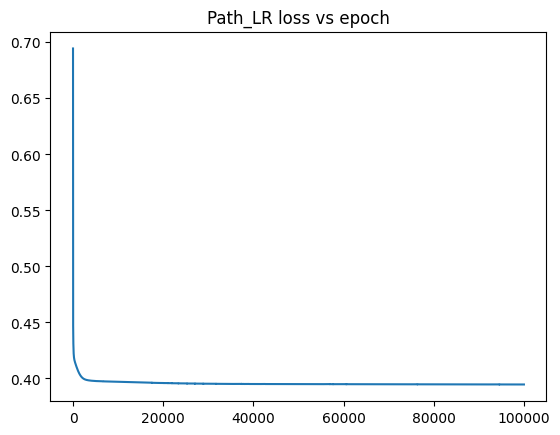

In [21]:
#@title **Load model Path_LR**
if infer_model:
  if infer_path_lr:
    # load dict of arrays
    dict_data = load(file_name_load_lr,allow_pickle=True)
    losses_lr=dict_data['arr_0']
    test_error_lr=dict_data['arr_1'].item()
    train_error_lr=dict_data['arr_2'].item()
    predictions_lr=dict_data['arr_3']
    Path_LR_obj_final=dict_data['arr_4'].item()
    Path_LR_obj_store=dict_data['arr_5']
    plt.figure()
    plt.title("Path_LR loss vs epoch")
    fig=plt.plot(losses_lr[:])
    if model_type == "Classification":
      print("test_error",test_error_lr/len(test_data_curr))
      print("train_error",train_error_lr/len(train_data_curr))
      print('DLGN acc=',np.sum(predictions_lr==test_labels_curr)/len(test_data_curr))
    if model_type == "Regression":
      print("test_error",test_error_lr)
      print("train_error",train_error_lr)

In [22]:
#@title **Data vs prediction scatter plot**
def data_pred_scatter_plot(predictions):
  plt.figure()
  plt.subplot(1, 2, 1) # row 1, col 2 index 1
  plt.scatter(test_data_curr[:,0], test_data_curr[:,1], c=test_labels_curr,vmin=-1,vmax=1)
  plt.colorbar()
  plt.title("Real labelled test data")
  plt.figure()

  plt.subplot(1, 2, 2) # index 2
  plt.scatter(test_data_curr[:,0], test_data_curr[:,1], c=predictions,vmin=-1,vmax=1)
  plt.title("Predicted Labelled test data")
  plt.colorbar()
  plt.show()

In [23]:
#@title **Calculate Path values**
if infer_model or infer_dlgn_lr:
  def path_value_cal(Model_obj,weight_model_type):
    complete_path_vals = np.zeros(tuple(num_hidden_nodes)) #(5,5,5)
    complete_paths = list(cartesian_prod(*[range(x) for x in num_hidden_nodes])) #(0,0,0)...(5,5,5)
    
    for path in complete_paths: #eg: path: (1,2,3)
      if weight_model_type == "DLGN":
        temp = np.dot(Model_obj.value_layers[0].weight.data.numpy()[path[0],:], np.ones(input_dim)) #weights of 1st layer 1 node (2x1) dot input(3000x2) = (3000x1) 
        for k in range(1,num_hidden_layers):
            temp *= Model_obj.value_layers[k].weight.data.numpy()[path[k], path[k-1]] #all intermediate node to node weights eg: layer 1 node 1 to layer 2 node 2 for above eg
        temp *= Model_obj.value_layers[num_hidden_layers].weight.data.numpy()[0, path[-1]] #last layer to output 
      if weight_model_type=="Path_LR" or weight_model_type =="DLGN_LR":
        temp = Model_obj.path_layer[0].weight.data.numpy()[0,path[0]*max_no_of_nodes**2+path[1]*max_no_of_nodes**1+path[2]*max_no_of_nodes**0] #for LR weight is 125 dimension so for path (1,2,3) corresponding entry is 1x5^2+2x5^1+3x5^0
      complete_path_vals[path]=temp
    return complete_paths,complete_path_vals #stores all path values

In [24]:
#@title **Path value of a particular path of a particular epoch**
def print_path_value(enter_path,enter_epoch,weight_model_type): #print value of a particular path for a particular epoch
  if infer_model or infer_dlgn_lr:
    if weight_model_type=="DLGN":
      Model_obj = DLGN_obj_store[int(np.sqrt(enter_epoch))]
    if weight_model_type == "Path_LR":
      Model_obj = Path_LR_obj_store[int(np.sqrt(enter_epoch))]
    if weight_model_type == "DLGN_LR":
      Model_obj = DLGN_LR_obj_store[int(np.sqrt(enter_epoch))]
    complete_paths,complete_path_vals = path_value_cal(Model_obj,weight_model_type)
    # print(f'Value of path {enter_path} of epoch {enter_epoch} is : {complete_path_vals[enter_path]}')
    return complete_path_vals[enter_path]

In [25]:
#@title **Visualization of node hyperplane for a particular epoch**
def show_node_hyp(enter_epoch,weight_model_type):
  if infer_model or infer_dlgn_lr:
    if infer_model:
      DLGN_obj = DLGN_obj_store[int(np.sqrt(enter_epoch))]
      effective_weights, effective_biases = DLGN_obj.return_gating_functions()
    X=test_data_curr[:,0]
    Y=test_data_curr[:,1]
    if weight_model_type == "DLGN":
      test_data_torch = torch.Tensor(test_data_curr) 
      values,gate_scores =DLGN_obj(test_data_torch)
      path_values = values[-1]
    if weight_model_type == "Path_LR":
      test_data_torch = torch.Tensor(path_fea_test) 
      Path_LR_obj = Path_LR_obj_store[int(np.sqrt(enter_epoch))]
      path_values = Path_LR_obj(test_data_torch)

    if weight_model_type == "DLGN_LR":
      DLGN_LR_obj = DLGN_LR_obj_store[int(np.sqrt(enter_epoch))]
      effective_weights, effective_biases = DLGN_LR_obj.return_gating_functions()
      test_data_torch = torch.Tensor(test_data_curr) 
      path_values,_ = DLGN_LR_obj(test_data_torch)
    if model_type == "Classification":
      test_preds = torch.cat((-1*path_values,path_values),dim=1)
      predictions = torch.argmax(test_preds,dim=1).numpy()
    if model_type == "Regression":
      test_preds = path_values
      predictions=test_preds.detach().numpy()

    no_rows=num_hidden_layers+1
    no_colns = max_no_of_nodes
    fig,ax=plt.subplots(no_rows,no_colns,figsize=(5*no_colns,4*no_rows)) 
    fig.tight_layout(pad=2)
    fig.text(0,0,s="Epoch "+str(enter_epoch))
    for k in range(no_colns//2):
      im_hide = ax[0,k].axis('off')
    for k in range(no_colns//2+2,no_colns):
      im_hide = ax[0,k].axis('off')
    im0=ax[0,no_colns//2].scatter(X, Y, c=test_labels_curr,vmin=-1,vmax=1)
    ax[0,no_colns//2].title.set_text("Real")
    ax[0,no_colns//2].set_xlim(-2,2)
    ax[0,no_colns//2].set_ylim(-4,4)
    divider = make_axes_locatable(ax[0,no_colns//2])
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(im0, cax=cax, orientation='vertical')
    im1=ax[0,no_colns//2+1].scatter(X, Y, c=predictions,vmin=-1,vmax=1)
    ax[0,no_colns//2+1].title.set_text("Predicted")
    ax[0,no_colns//2+1].set_xlim(-2,2)
    ax[0,no_colns//2+1].set_ylim(-4,4)
    divider = make_axes_locatable(ax[0,no_colns//2+1])
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(im1, cax=cax, orientation='vertical')
    for j in range(num_hidden_layers):
      for i in range( num_hidden_nodes[j]):
        weight = effective_weights[j][i].data.numpy()
        bias = effective_biases[j][i].data.numpy()
        Z = ((test_data_curr@weight.T)+bias)>0
        line_eq = (-bias - X*weight[0])/weight[1]
        im=ax[j+1,i].scatter(X, Y, c=Z,vmin=-1,vmax=1)
        im1=ax[j+1,i].plot(X,line_eq,label="("+str(round(weight.data[0],4))+")x+"+"("+str(round(weight.data[1],4))+")y+"+"("+str(round(bias.item(),2))+")=0")
        ax[j+1,i].set_xlim(-2,2)
        ax[j+1,i].set_ylim(-4,4)
        ax[j+1,i].title.set_text("Layer: "+str(j+1)+" Node: "+str(i+1))
        ax[j+1,i].legend()
        divider = make_axes_locatable(ax[j+1,i])
        cax = divider.append_axes('right', size='5%', pad=0.05)
        fig.colorbar(im, cax=cax, orientation='vertical')
    path0="/content/drive/MyDrive/Research/DLGN_fixed_node/"
    if save_img:
      fig.savefig(str(path0)+"Epoch_"+str(enter_epoch)+".pdf", dpi=300,format="pdf")					

In [26]:
#@title **Node hyperplane for best model**
if infer_model:
  if best_epoch_show:
    effective_weights, effective_biases = DLGN_obj_final.return_gating_functions()
    X=test_data_curr[:,0]
    Y=test_data_curr[:,1]
    no_rows=num_hidden_layers+1
    no_colns = max_no_of_nodes
    fig,ax=plt.subplots(no_rows,no_colns,figsize=(5*no_colns,4*no_rows)) 
    fig.tight_layout(pad=2)
    fig.text(0,0,s="Best Epoch")
    for k in range(no_colns//2):
      im_hide = ax[0,k].axis('off')
    for k in range(no_colns//2+2,no_colns):
      im_hide = ax[0,k].axis('off')
    im0=ax[0,no_colns//2].scatter(X, Y, c=test_labels_curr,vmin=-1,vmax=1)
    ax[0,no_colns//2].title.set_text("Real")
    ax[0,no_colns//2].set_xlim(-2,2)
    ax[0,no_colns//2].set_ylim(-4,4)
    divider = make_axes_locatable(ax[0,no_colns//2])
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(im0, cax=cax, orientation='vertical')
    im1=ax[0,no_colns//2+1].scatter(X, Y, c=predictions_dlgn,vmin=-1,vmax=1)
    ax[0,no_colns//2+1].title.set_text("Predicted")
    ax[0,no_colns//2+1].set_xlim(-2,2)
    ax[0,no_colns//2+1].set_ylim(-4,4)
    divider = make_axes_locatable(ax[0,no_colns//2+1])
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(im1, cax=cax, orientation='vertical')
    for j in range(num_hidden_layers):
      for i in range( num_hidden_nodes[j]):
        weight = effective_weights[j][i].data.numpy()
        bias = effective_biases[j][i].data.numpy()
        Z = ((test_data_curr@weight.T)+bias)>0
        line_eq = (-bias - X*weight[0])/weight[1]
        im=ax[j+1,i].scatter(X, Y, c=Z,vmin=-1,vmax=1)
        im1=ax[j+1,i].plot(X,line_eq,label="("+str(round(weight.data[0],4))+")x+"+"("+str(round(weight.data[1],4))+")y+"+"("+str(round(bias.item(),2))+")=0")
        ax[j+1,i].set_xlim(-2,2)
        ax[j+1,i].set_ylim(-4,4)
        ax[j+1,i].title.set_text("Layer: "+str(j+1)+" Node: "+str(i+1))
        ax[j+1,i].legend()
        divider = make_axes_locatable(ax[j+1,i])
        cax = divider.append_axes('right', size='5%', pad=0.05)
        fig.colorbar(im, cax=cax, orientation='vertical')
    # fig.subplots_adjust(right=0.8)
    # cbar_ax = fig.add_axes([0.85, 0.12, 0.01, 0.82])
    # fig.colorbar(im0, cax=cbar_ax)
    path0="/content/drive/MyDrive/Research/DLGN_fixed_node/"
    if save_img:
      fig.savefig(str(path0)+"Best_epoch.pdf", dpi=300,format="pdf")

In [27]:
#@title **Change of node hyperplane for each layer**
def perfectCube(N) :
	cube_root = round(N**(1/3));
	if cube_root * cube_root * cube_root == N :
		return True;
	else :
		return False;

if infer_model or infer_dlgn_lr:
	def show_node_hyp_eacepoch(weight_model_type):
		if test_on_train_data:
			test_data_curr = train_data_curr
			test_labels_curr = train_labels_curr
		if (weight_model_type == "DLGN_LR"):
			DLGN_obj_store_model = DLGN_LR_obj_store
		else:
			DLGN_obj_store_model = DLGN_obj_store
		for epoch_no in range(len(DLGN_obj_store_model)):
			if ((epoch_no%10)==0):
				print("________________________________")
				print("=======Epoch no: ", epoch_no**2)
				print("________________________________")

				effective_weights, effective_biases = DLGN_obj_store_model[epoch_no].return_gating_functions()
				X=test_data_curr[:,0]
				Y=test_data_curr[:,1]
				test_data_torch = torch.Tensor(test_data_curr)
				values,gate_scores =DLGN_obj_store_model[epoch_no](test_data_torch)
				if weight_model_type != "DLGN_LR":
					values = values[-1]
				if model_type == "Classification":
					test_preds = torch.cat((-1*values,values),dim=1)
					predictions = torch.argmax(test_preds,dim=1).numpy()
				if model_type == "Regression":
					test_preds = values
					predictions=test_preds.detach().numpy()

				no_rows=num_hidden_layers+1
				no_colns = max_no_of_nodes
				fig,ax=plt.subplots(no_rows,no_colns,figsize=(5*no_colns,4*no_rows)) 
				fig.tight_layout(pad=2)
				fig.text(0,0,s="Epoch no: "+ str(epoch_no**2))
				for k in range(no_colns//2):
					im_hide = ax[0,k].axis('off')
				for k in range(no_colns//2+2,no_colns):
					im_hide = ax[0,k].axis('off')
				im0=ax[0,no_colns//2].scatter(X, Y, c=test_labels_curr,vmin=-1,vmax=1)
				ax[0,no_colns//2].title.set_text("Real")
				ax[0,no_colns//2].set_xlim(-2,2)
				ax[0,no_colns//2].set_ylim(-4,4)
				divider = make_axes_locatable(ax[0,no_colns//2])
				cax = divider.append_axes('right', size='5%', pad=0.05)
				fig.colorbar(im0, cax=cax, orientation='vertical')

				im1=ax[0,no_colns//2+1].scatter(X, Y, c=predictions,vmin=-1,vmax=1)
				ax[0,no_colns//2+1].title.set_text("Predicted")
				ax[0,no_colns//2+1].set_xlim(-2,2)
				ax[0,no_colns//2+1].set_ylim(-4,4)
				divider = make_axes_locatable(ax[0,no_colns//2+1])
				cax = divider.append_axes('right', size='5%', pad=0.05)
				fig.colorbar(im1, cax=cax, orientation='vertical')

				for j in range(num_hidden_layers):
					for i in range( num_hidden_nodes[j]):
						weight = effective_weights[j][i].data.numpy()
						bias = effective_biases[j][i].data.numpy()
						Z = ((test_data_curr@weight.T)+bias)>0
						line_eq = (-bias - X*weight[0])/weight[1]

						im=ax[j+1,i].scatter(X, Y, c=Z,vmin=-1,vmax=1)
						im1=ax[j+1,i].plot(X,line_eq,label="("+str(round(weight.data[0],4))+")x+"+"("+str(round(weight.data[1],4))+")y+"+"("+str(round(bias.item(),4))+")=0")
						ax[j+1,i].set_xlim(-2,2)
						ax[j+1,i].set_ylim(-4,4)
						ax[j+1,i].title.set_text("Layer: "+str(j+1)+" Node: "+str(i+1))
						ax[j+1,i].legend()
						divider = make_axes_locatable(ax[j+1,i])
						cax = divider.append_axes('right', size='5%', pad=0.05)
						fig.colorbar(im, cax=cax, orientation='vertical')
				# fig.subplots_adjust(right=0.8)
				# cbar_ax = fig.add_axes([0.85, 0.12, 0.01, 0.82])
				# fig.colorbar(im0, cax=cbar_ax)
				path="/content/drive/MyDrive/Research/DLGN_fixed_node/Layer_3_Node_2/"
				if save_img:
					fig.savefig(str(path)+"Epoch_"+str(epoch_no**2)+"_.png", dpi=300)
				plt.show


In [28]:
#@title **Visualization of a particular path for a particular epoch**
def show_path_hyp(enter_path,enter_epoch,weight_model_type):
  if (weight_model_type == "DLGN_LR"):
    DLGN_obj_store_model = DLGN_LR_obj_store
  else:
    DLGN_obj_store_model = DLGN_obj_store


  DLGN_obj = DLGN_obj_store_model[int(np.sqrt(enter_epoch))]
  effective_weights, effective_biases = DLGN_obj.return_gating_functions()
  X=test_data_curr[:,0]
  Y=test_data_curr[:,1]
  fig,ax=plt.subplots(1,2,figsize=(5*2,4)) 
  fig.tight_layout(pad=2)
  fig.text(0,0,s="Epoch "+str(enter_epoch))
  im0=ax[0].scatter(X, Y, c=test_labels_curr,vmin=-1,vmax=1)
  ax[0].title.set_text("Real Data")
  ax[0].set_xlim(-2,2)
  ax[0].set_ylim(-4,4)
  divider = make_axes_locatable(ax[0])
  cax = divider.append_axes('right', size='5%', pad=0.05)
  fig.colorbar(im0, cax=cax, orientation='vertical')
  Z_path = []
  for j in range(len(enter_path)):
    weight = effective_weights[j][enter_path[j]].data.numpy()
    bias = effective_biases[j][enter_path[j]].data.numpy()
    Z = ((test_data_curr@weight.T)+bias)>0
    Z_path.append(Z)
  Z_result = Z_path[0]
  for i in range(1,len(Z_path)):
    Z_result = Z_result & Z_path[i]

  data_frac_by_path = np.count_nonzero(Z_result)/len(test_labels_curr)*100 #Stregth of the path defined as fraction of data points active by that path
  Z_res_path=Z_result*test_labels_curr
  Z_res_non_zero = Z_res_path[np.nonzero(Z_res_path)]
  path_std=np.std(Z_res_non_zero)##Path purity defined as the path variance i.e., variance of the data points active for that path
  path_mean=np.mean(Z_res_non_zero)

  im1=ax[1].scatter(X, Y, c=Z_result,vmin=-1,vmax=1)
  ax[1].text(0.5,.9,"data_frac_by_path: "+str(round(data_frac_by_path,2)),horizontalalignment='center', verticalalignment='center', transform=ax[1].transAxes)
  ax[1].text(0.5,0.1,"Path_mean: "+str(round(path_mean,2))+" ,std: "+str(round(path_std,2)),horizontalalignment='center', verticalalignment='center', transform=ax[1].transAxes)

  ax[1].title.set_text(str(enter_path)+" Path visualization")
  ax[1].set_xlim(-2,2)
  ax[1].set_ylim(-4,4)
  divider = make_axes_locatable(ax[1])
  cax = divider.append_axes('right', size='5%', pad=0.05)
  fig.colorbar(im0, cax=cax, orientation='vertical')
  path0="/content/drive/MyDrive/Research/DLGN_fixed_node/"
  if save_img:
    fig.savefig(str(path0)+"Path_viz_Epoch_"+str(enter_epoch)+".pdf", dpi=300,format="pdf")


def return_path_hyp(enter_path,enter_epoch,weight_model_type):
  if (weight_model_type == "DLGN_LR"):
    DLGN_obj_store_model = DLGN_LR_obj_store
  else:
    DLGN_obj_store_model = DLGN_obj_store

  DLGN_obj = DLGN_obj_store_model[int(np.sqrt(enter_epoch))]
  effective_weights, effective_biases = DLGN_obj.return_gating_functions()
  Z_path = []
  for j in range(len(enter_path)):
    weight = effective_weights[j][enter_path[j]].data.numpy()
    bias = effective_biases[j][enter_path[j]].data.numpy()
    Z = ((test_data_curr@weight.T)+bias)>0
    Z_path.append(Z)
  Z_result = Z_path[0]
  for i in range(1,len(Z_path)):
    Z_result = Z_result & Z_path[i]
  data_frac_by_path = np.count_nonzero(Z_result)/len(test_labels_curr)*100 #Stregth of the path defined as fraction of data points active by that path
  Z_res_path=Z_result*test_labels_curr
  Z_res_non_zero = Z_res_path[np.nonzero(Z_res_path)]
  path_std=np.std(Z_res_non_zero)##Path purity defined as the path variance i.e., variance of the data points active for that path
  path_mean=np.mean(Z_res_non_zero)
  return Z_result,round(data_frac_by_path,2),round(path_mean,2),round(path_std,2)

In [29]:
# DLGN_obj = DLGN_obj_store[0]
# DLGN_obj.value_layers[-1].weight
# DLGN_obj.value_layers[-2].weight

In [30]:
#@title **Change of W_&_B for all node**
def change_wb(weight_model_type):
  if infer_model or infer_dlgn_lr:
    # layer_num = 3
    # node_num = 2
    if (weight_model_type == "DLGN_LR"):
      DLGN_obj_store_model = DLGN_LR_obj_store
    else:
      DLGN_obj_store_model = DLGN_obj_store
    no_rows=num_hidden_layers
    no_colns = max_no_of_nodes
    fig,ax=plt.subplots(no_rows,no_colns,figsize=(5*no_colns,4*no_rows)) 
    fig.tight_layout(pad=2)
    fig.text(0,0,s="Change of weights")
    for layer_num in range(num_hidden_layers):
      for node_num in range(num_hidden_nodes[layer_num]):
        weight_0 = []
        weight_1 = []
        bias = []
        epoch_count=range(len(DLGN_obj_store_model))
        for epoch_no in range(len(DLGN_obj_store_model)):
          effective_weights, effective_biases = DLGN_obj_store_model[epoch_no].return_gating_functions()
          weight_0.append(effective_weights[layer_num][node_num].data.numpy()[0])
          weight_1.append(effective_weights[layer_num][node_num].data.numpy()[1])
          bias.append(effective_biases[layer_num][node_num].data.numpy())
        im1=ax[layer_num,node_num].plot(epoch_count,weight_0,label="Weight_0")
        im2=ax[layer_num,node_num].plot(epoch_count,weight_1,label="Weight_1")
        im3=ax[layer_num,node_num].plot(epoch_count,bias,label="bias")
        ax[layer_num,node_num].title.set_text("Layer: "+str(layer_num+1)+" Node: "+str(node_num+1))
        ax[layer_num,node_num].legend()

In [31]:
#@title **Plot Path Value variation**
def plot_path_value_variation(enter_path,plot_epoch,weight_model_type): #plot_epoch is till which epoch want to plot
  path_value=[]
  path_epoch_count = []
  for i in range(plot_epoch):
    if(perfectSq(i)):
      path_epoch_count.append(i)
      path_value.append(print_path_value(enter_path,i,weight_model_type))
  plt.figure()
  plt.plot(path_epoch_count,path_value)

In [32]:
#@title **Sanity check of path decomposition**
def check_sanity(weight_model_type,enter_epoch):
  X=test_data_curr[:,0]
  Y=test_data_curr[:,1]
  Z=np.zeros(X.shape)
  for i in range(max_no_of_nodes):
    for j in range(max_no_of_nodes):
      for k in range(max_no_of_nodes):
        enter_path=(i,j,k)
        val=print_path_value(enter_path,enter_epoch,weight_model_type)
        Z_result,data_frac_by_path,path_mean,path_std=return_path_hyp(enter_path,enter_epoch,weight_model_type)
        Z+=val*Z_result
  plt.scatter(X,Y,c=Z,vmin=-1,vmax=1)
  plt.colorbar()
  plt.figure()
  plt.scatter(X,Y,c=test_labels_curr,vmin=-1,vmax=1)
  plt.colorbar()

In [33]:
#@title **Array of dict storing path,path_val,data frac,mean,std**
def path_array(plot_epoch,weight_model_type):
  path_val_store = []
  for i in range(max_no_of_nodes):
    for j in range(max_no_of_nodes):
      for k in range(max_no_of_nodes):
        enter_path=(i,j,k)
        path_value=[]
        path_epoch_count = []
        for pe in range(plot_epoch):
          if(perfectSq(pe)):
            path_epoch_count.append(pe)
            path_value.append(round(print_path_value(enter_path,pe,weight_model_type),3))
        Z_result,data_frac_by_path,path_mean,path_std=return_path_hyp(enter_path,5000,weight_model_type)
        Dict = {}
        Dict['val']=(path_epoch_count,path_value)
        Dict['path']=enter_path
        Dict['data_frac_by_path']=data_frac_by_path
        Dict['path_mean']=path_mean
        Dict['path_std']=path_std
        path_val_store.append(Dict)
  return path_val_store

In [34]:
#@title **Printing vals for one path**
def print_any_path(plot_epoch,weight_model_type,find_path=(0,0,0)):
  path_val_store = path_array(plot_epoch,weight_model_type)
  newlist = sorted(path_val_store, key=itemgetter('path')) 
  return newlist,newlist[find_path[0]*max_no_of_nodes**2+find_path[1]*max_no_of_nodes+find_path[2]]  

In [35]:
#@title **5x25 path vals**
def plot_all_paths(plot_epoch,weight_model_type):
  newlist,_ = print_any_path(plot_epoch,weight_model_type)
  for index in range(max_no_of_nodes**num_hidden_layers):
    if(index%5==0):
      plt.figure(figsize=(5,5))
    plt.plot(newlist[index]['val'][0],newlist[index]['val'][1],label="p: "+str(newlist[index]['path'])+" f: "+str(newlist[index]['data_frac_by_path'])+" m: "+str(newlist[index]['path_mean'])+" s: "+str(newlist[index]['path_std']))
    plt.legend(loc="upper left")
    plt.ylim(-.3, .3)

**Results**

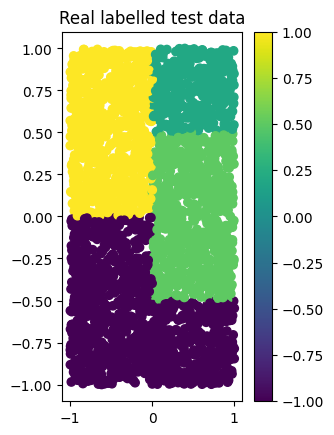

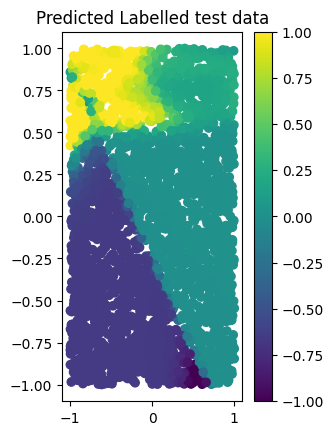

/usr/local/lib/python3.9/dist-packages/numpy/core/_methods.py:264: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/usr/local/lib/python3.9/dist-packages/numpy/core/_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/usr/local/lib/python3.9/dist-packages/numpy/core/_methods.py:256: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.9/dist-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.9/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)
<ipython-input-35-54b9ed8c1936>:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotli

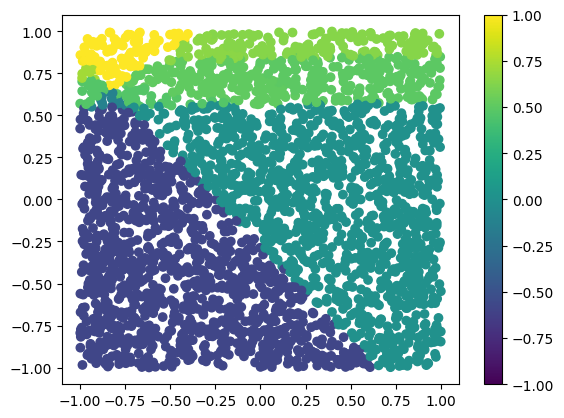

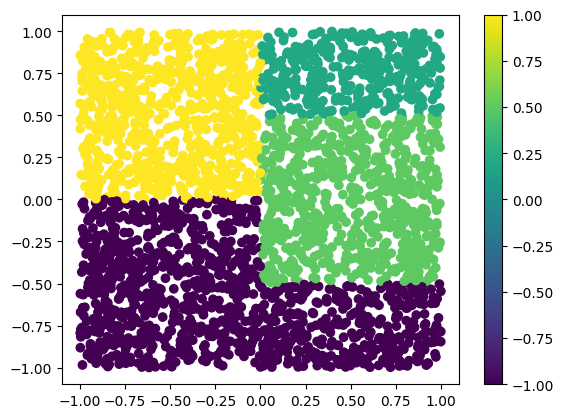

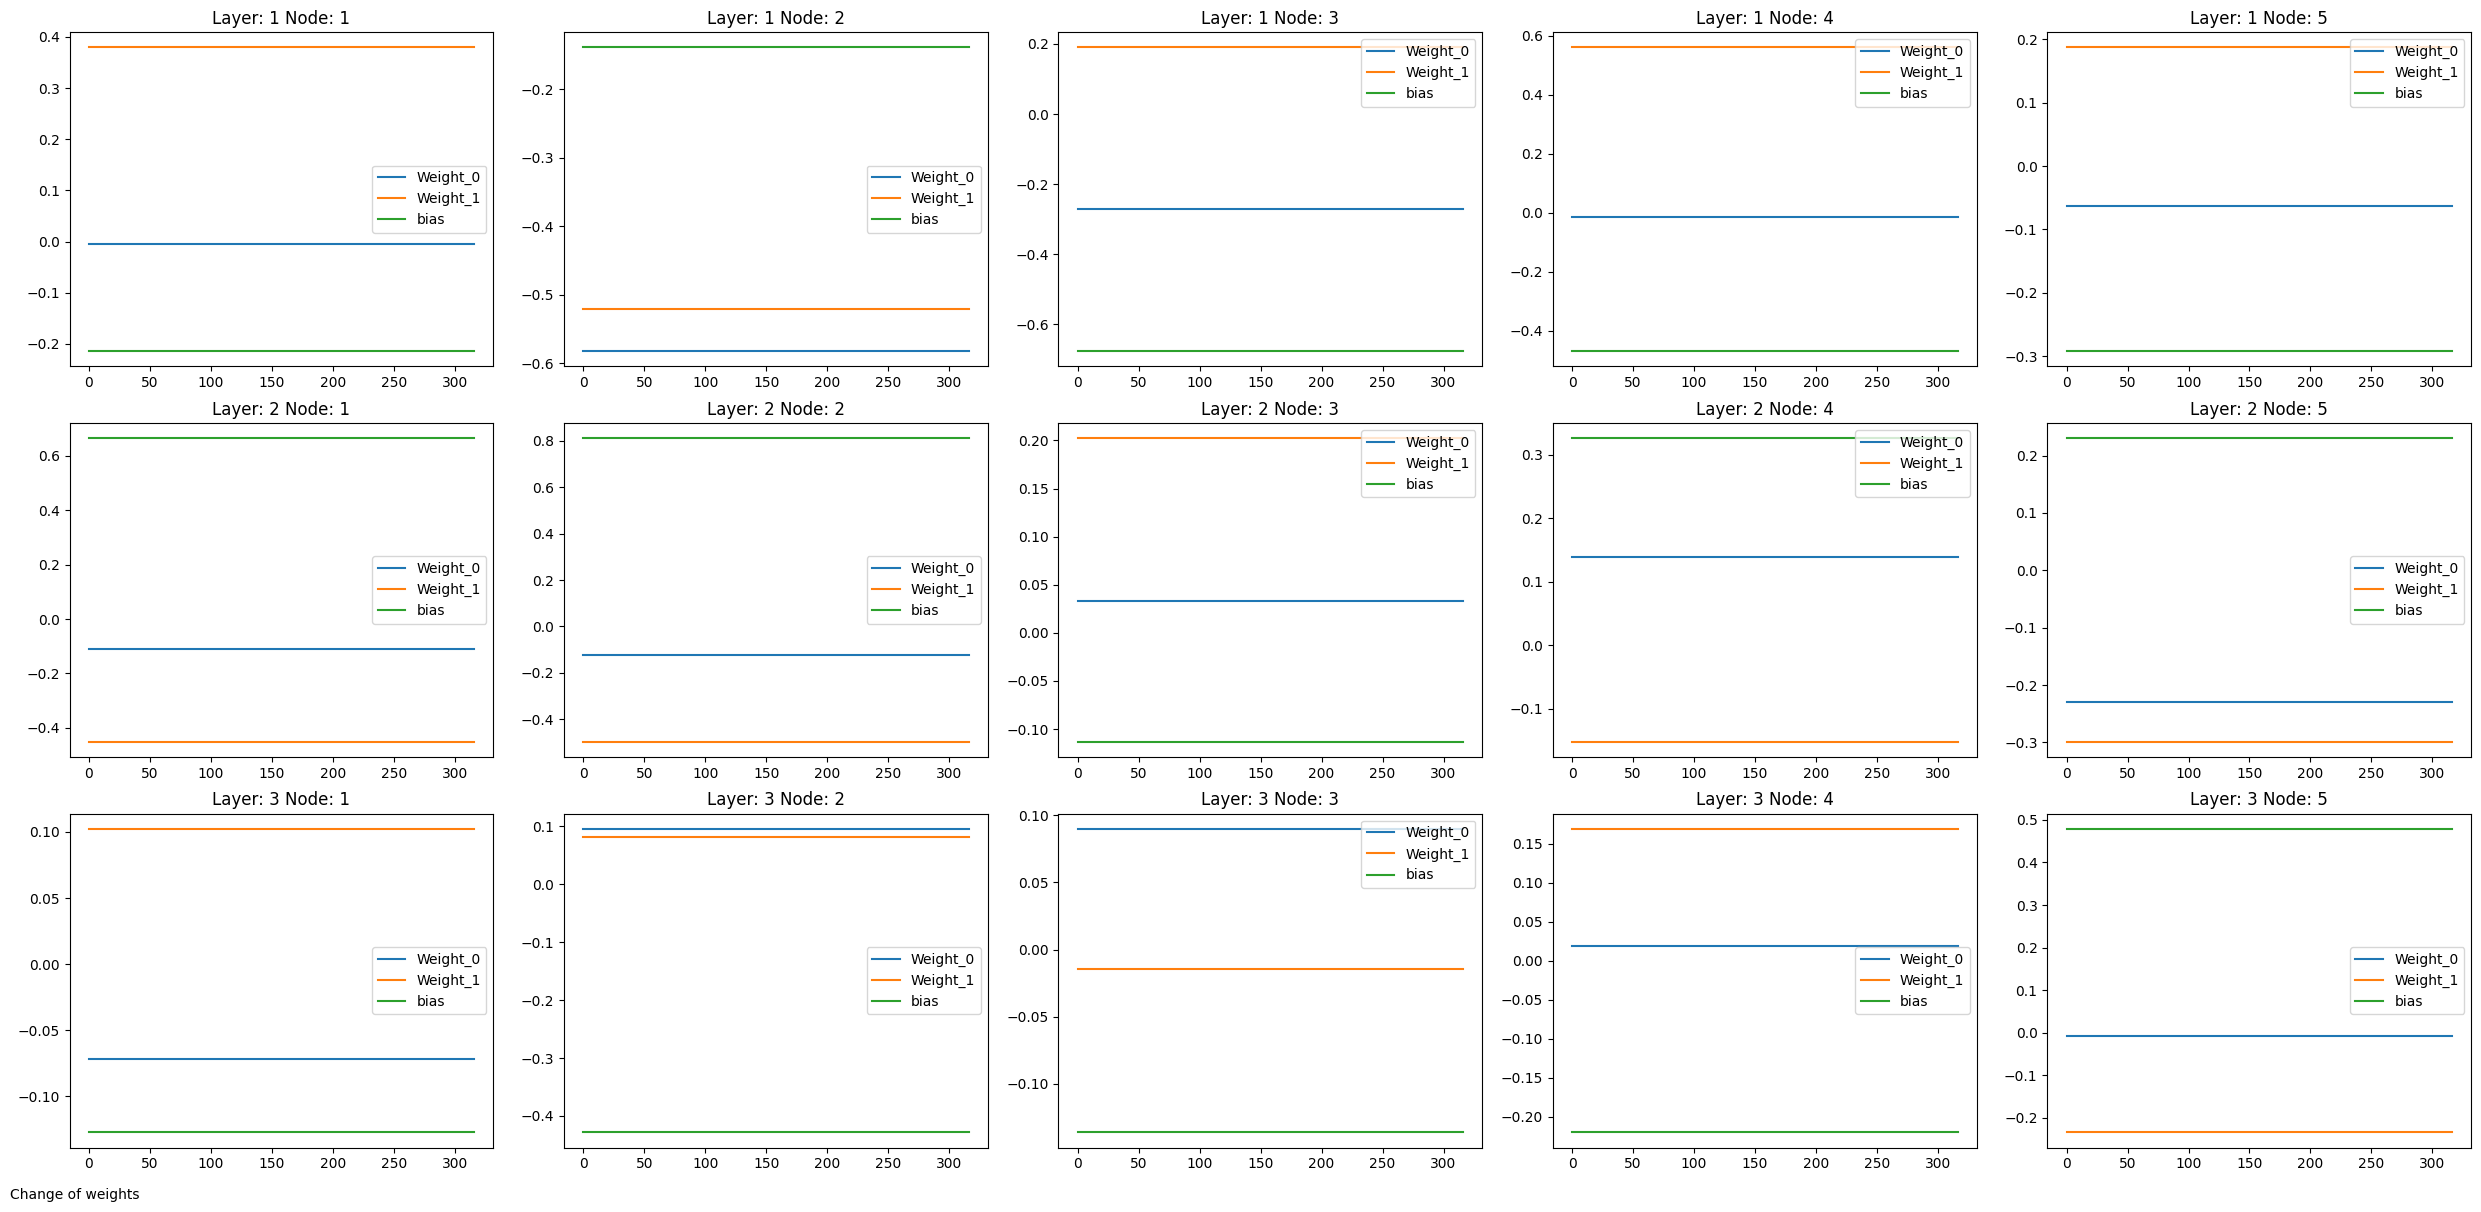

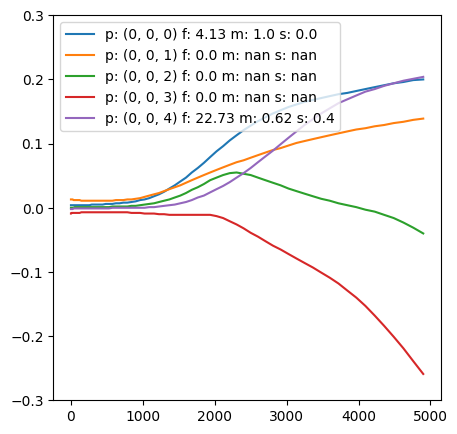

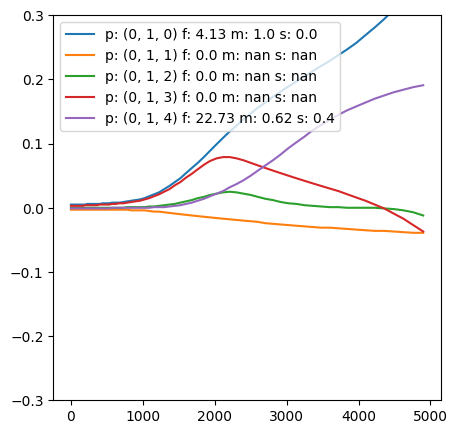

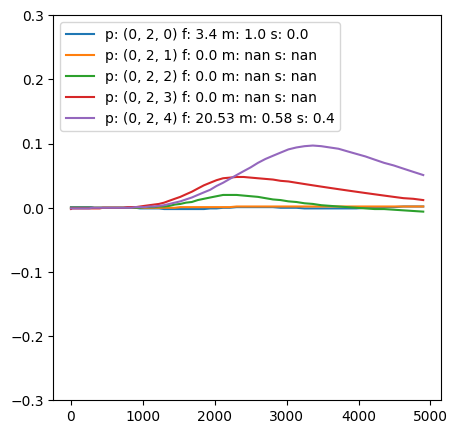

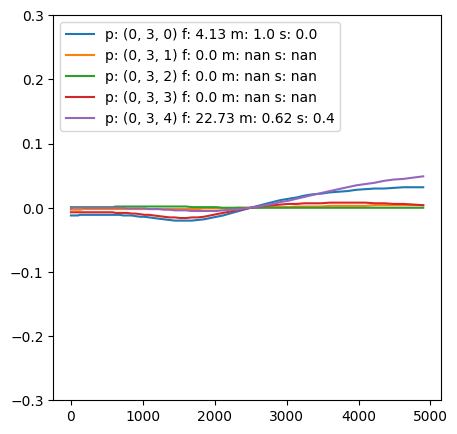

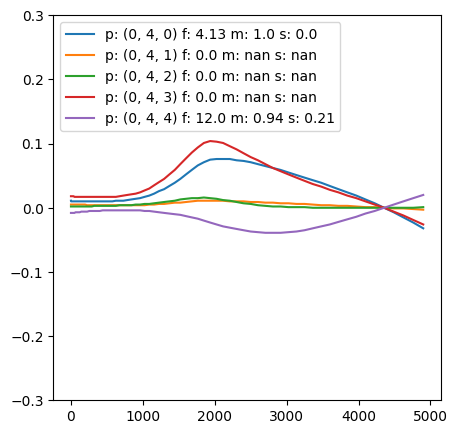

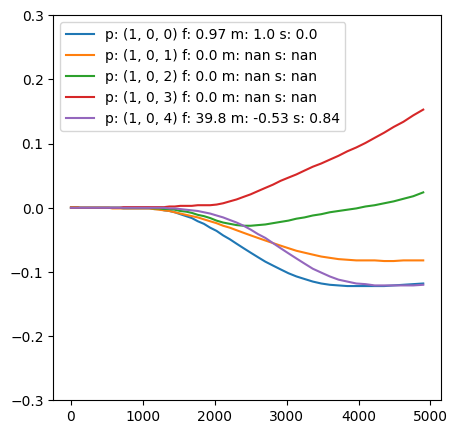

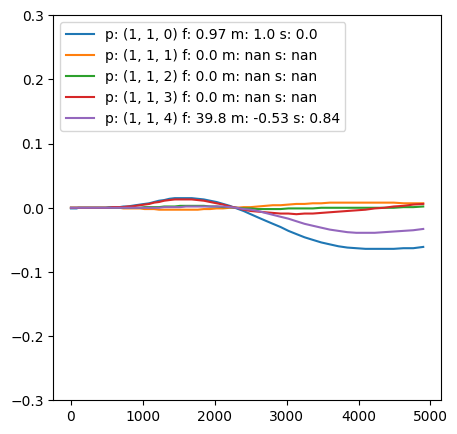

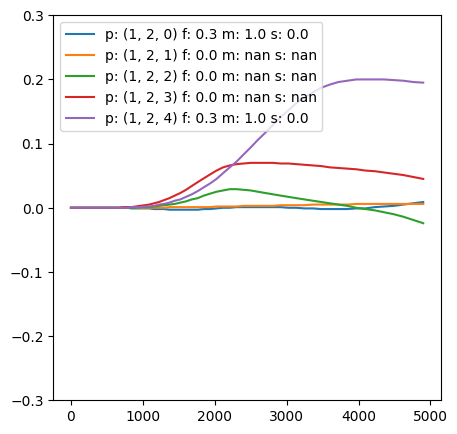

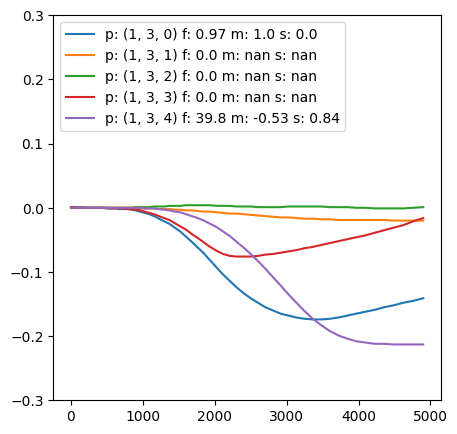

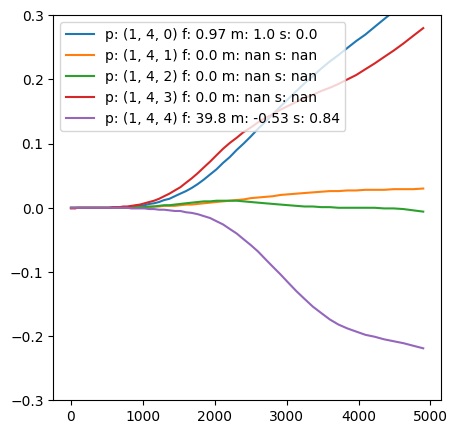

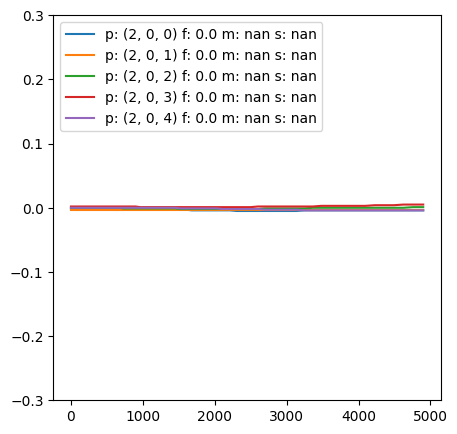

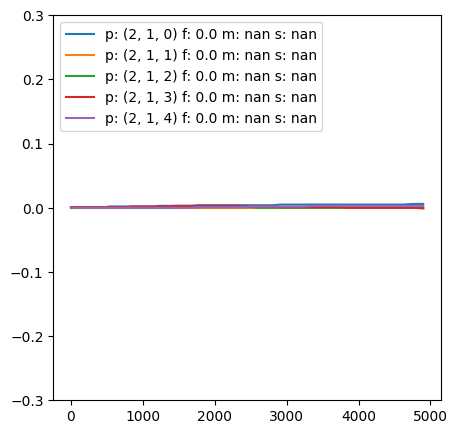

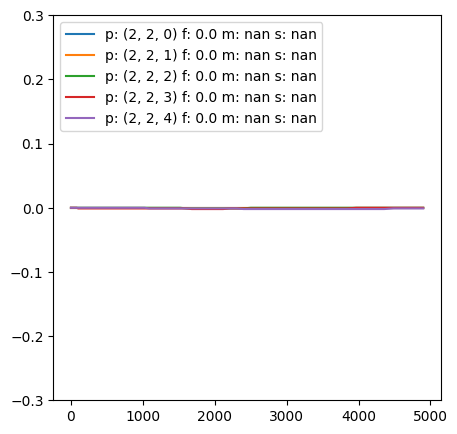

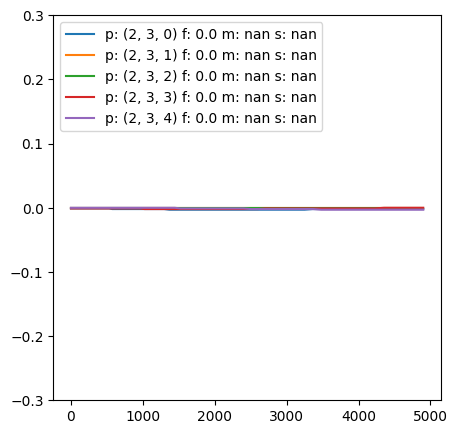

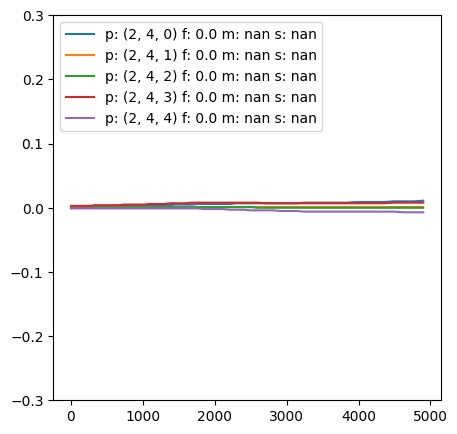

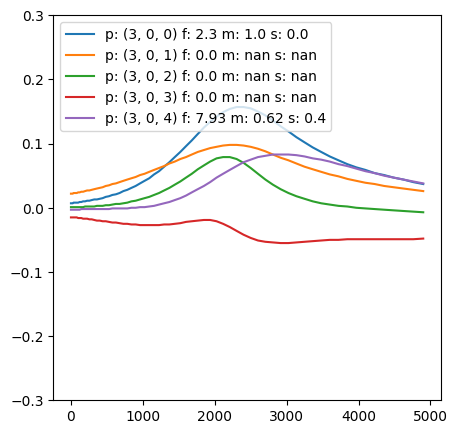

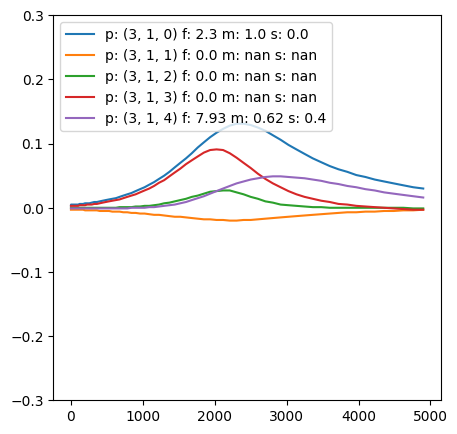

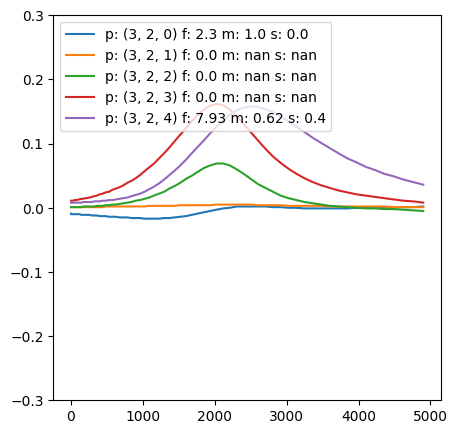

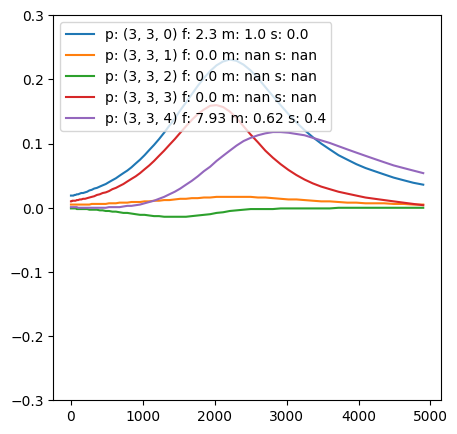

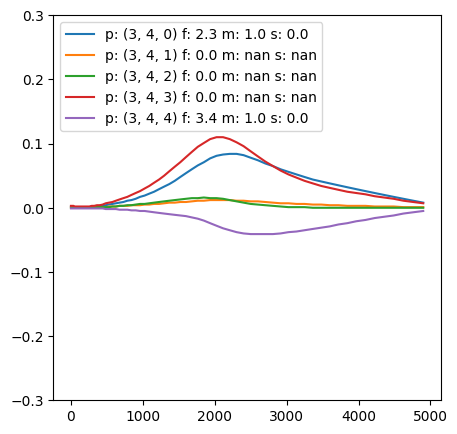

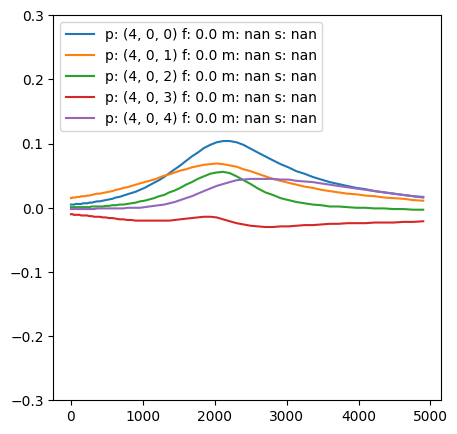

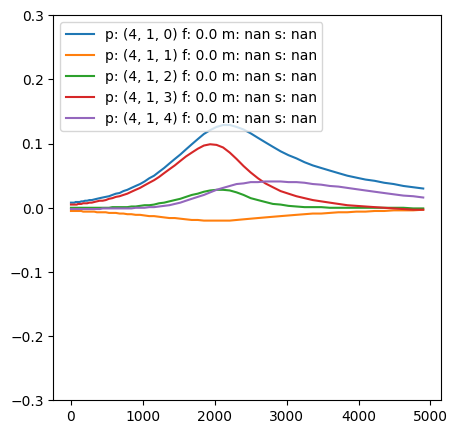

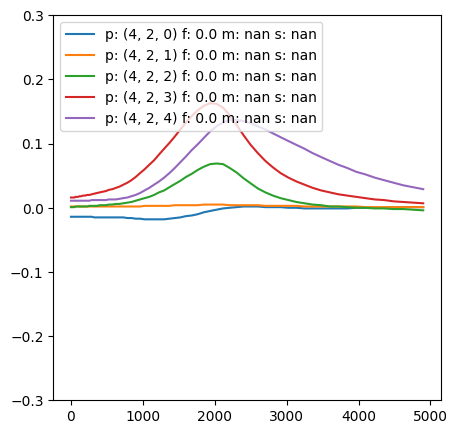

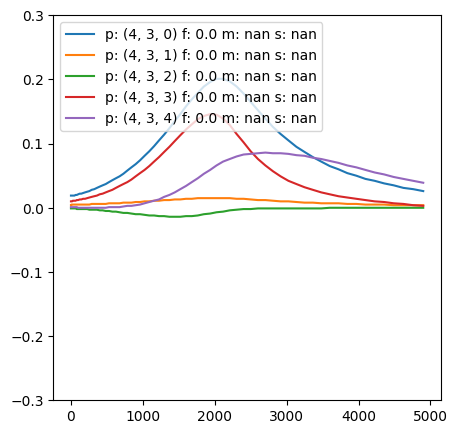

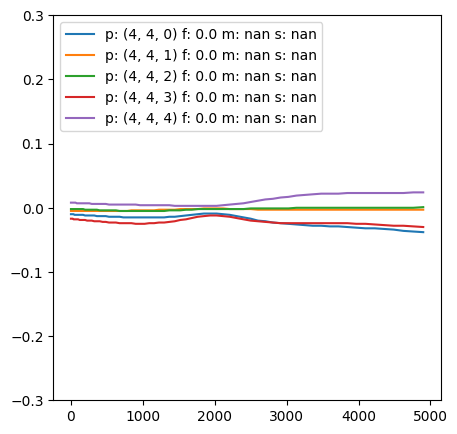

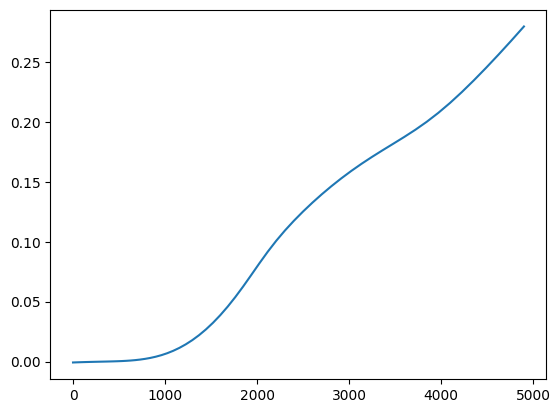

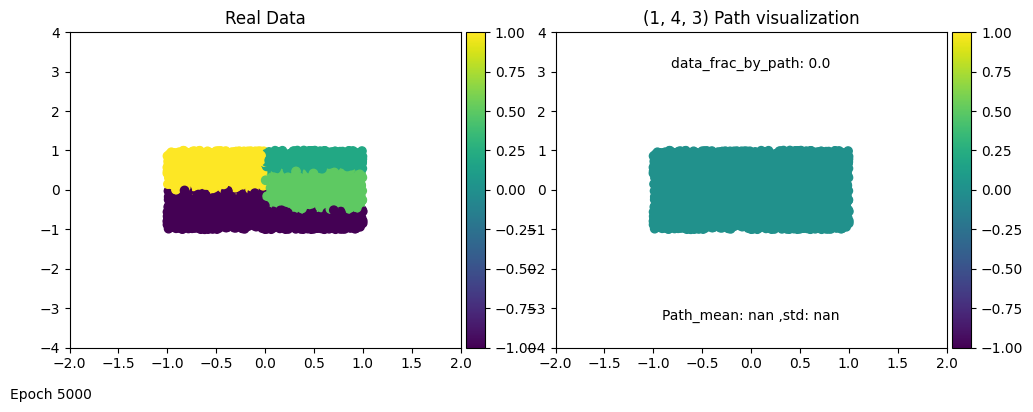

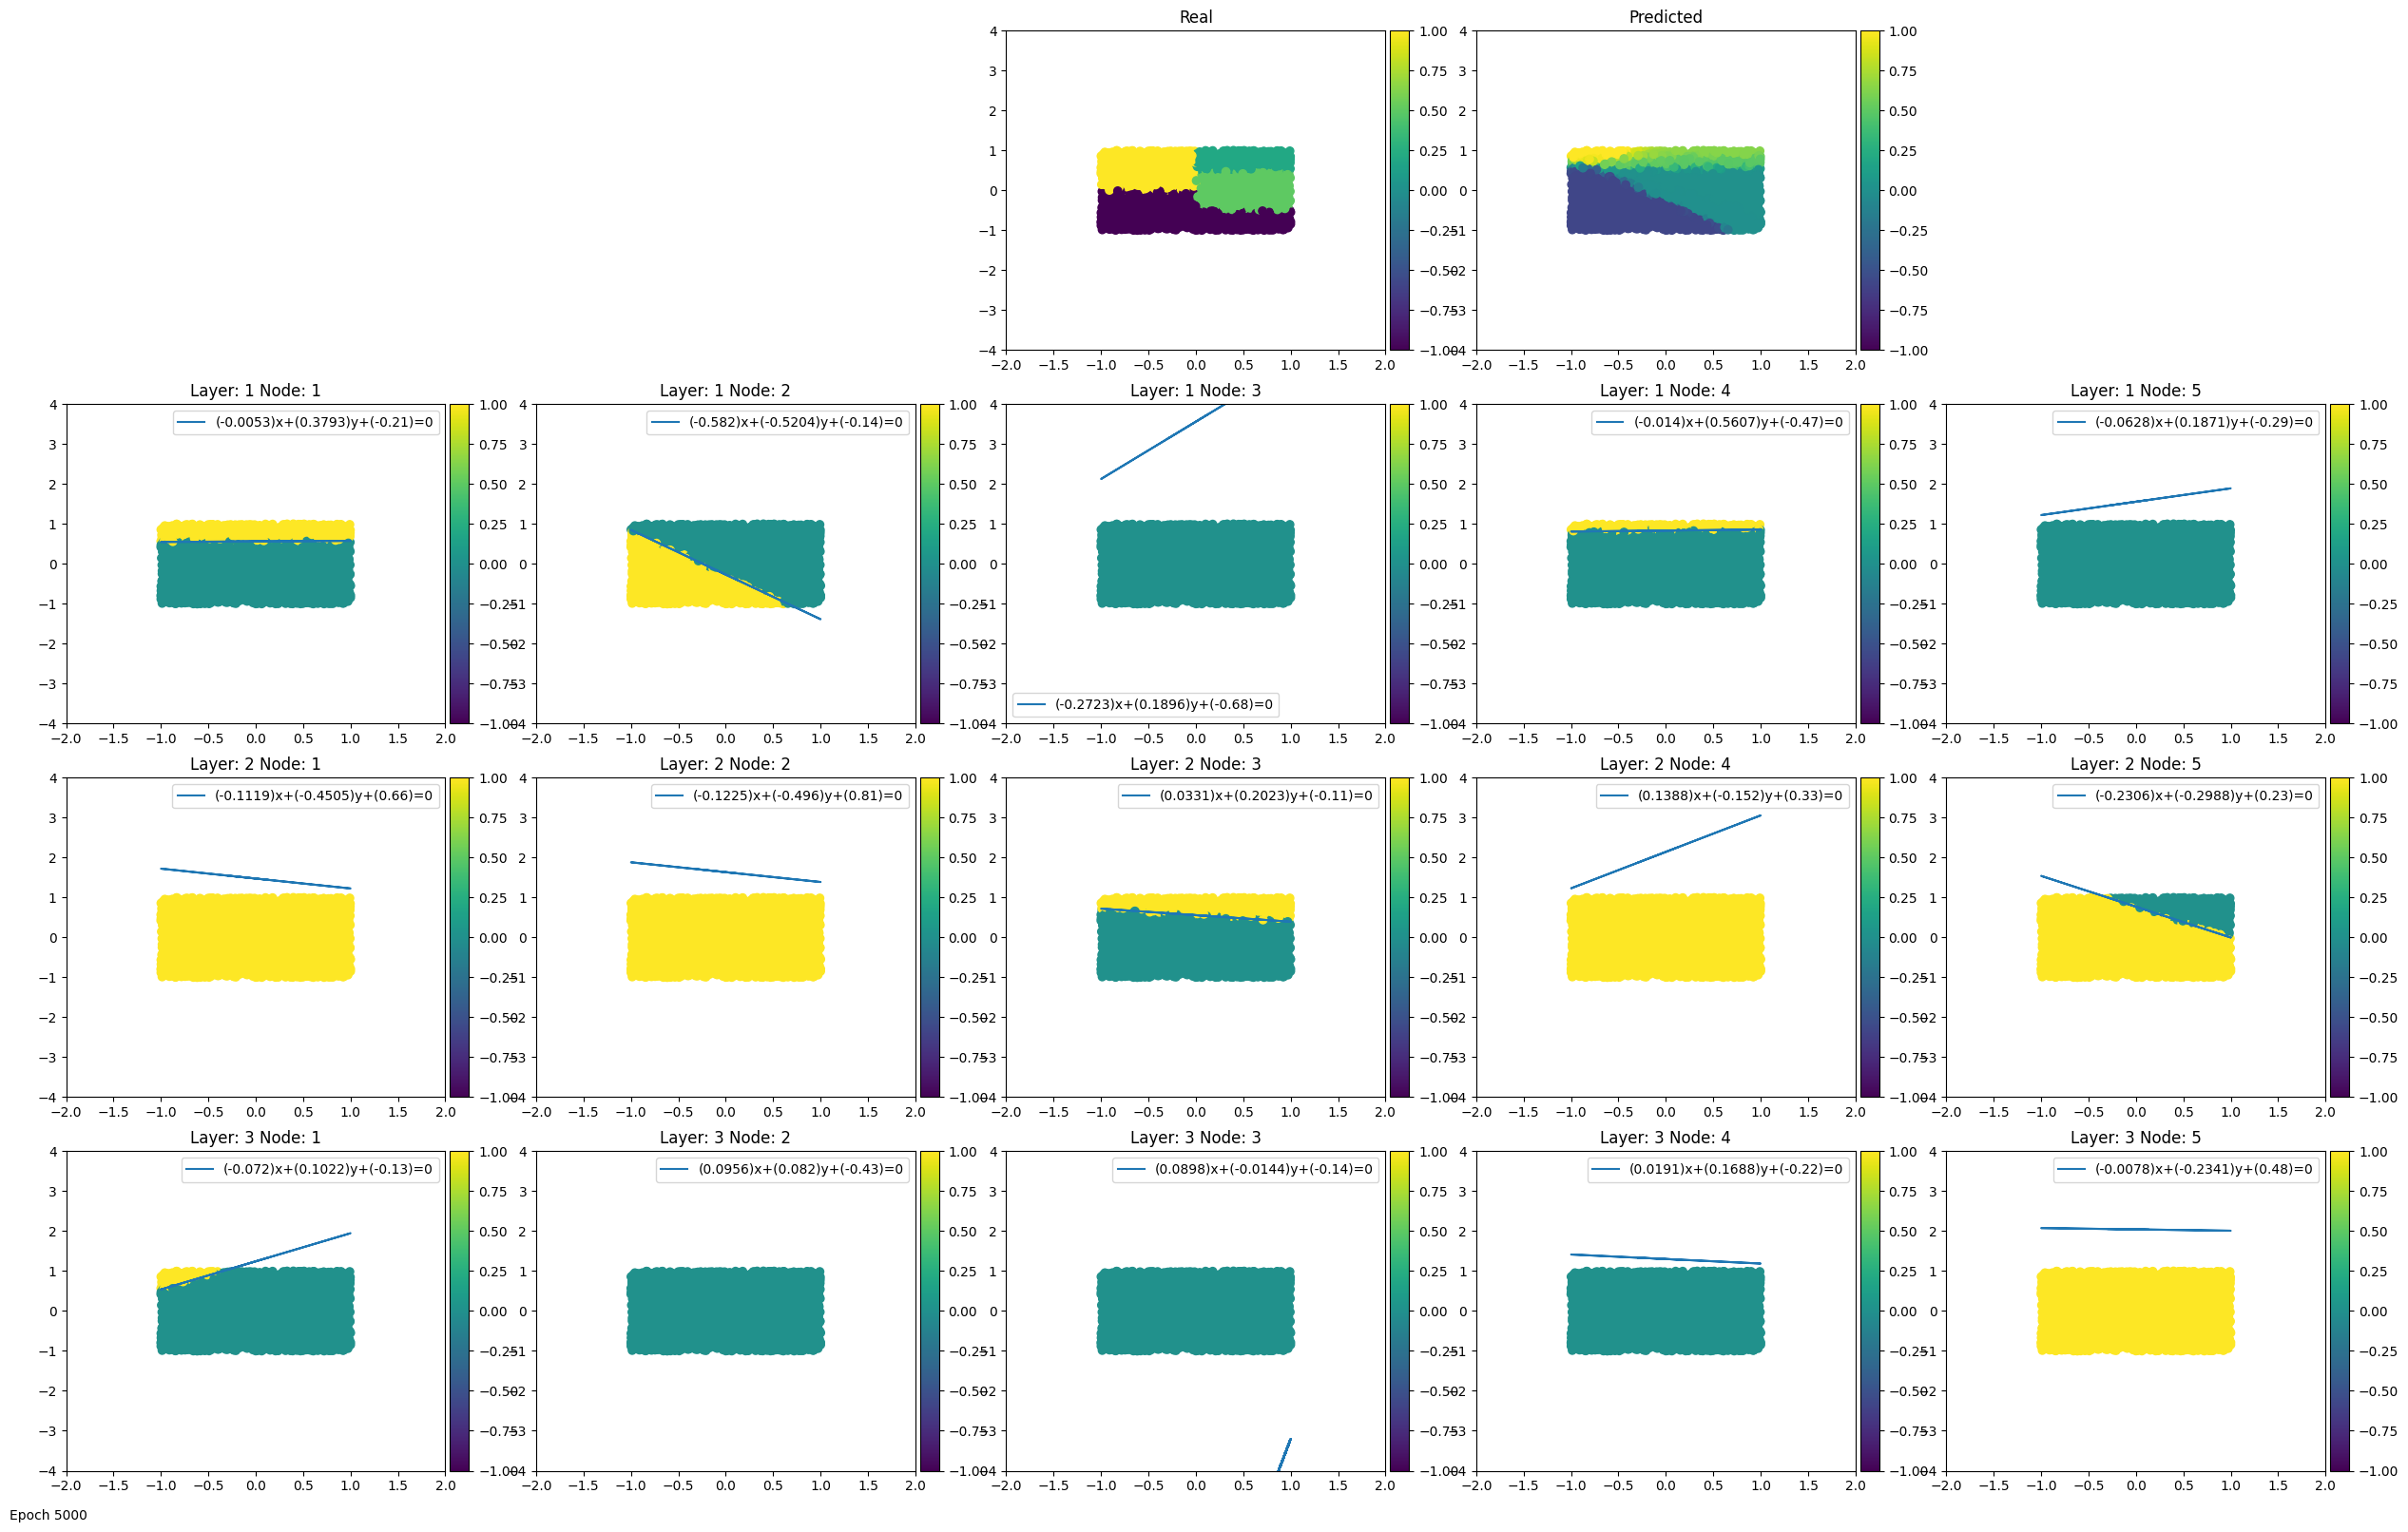

In [36]:
if infer_model: #if we have similar kind of paths only one of them vary much rest don't vary that much (2,1/2,0/3) (1,4,0/1/3/4) seed 365
  enter_path = (1,4,3) #(2,2,3)#(2,1,0)#(2,1,3)#(1,4,0)#(1,4,3)#(1,4,1)#(1,4,4) #(2,0,3) #(2,2,0)  
  plot_epoch = 5000
  enter_epoch = 5000
  weight_model_type = "DLGN"
  data_pred_scatter_plot(predictions_dlgn)
  check_sanity(weight_model_type,enter_epoch)
  change_wb(weight_model_type)
  _,path_val=print_any_path(plot_epoch,weight_model_type,find_path=enter_path)
  plot_all_paths(plot_epoch,weight_model_type)
  #**Path visualization of one path**
  plot_path_value_variation(enter_path,plot_epoch,weight_model_type)
  show_path_hyp(enter_path,enter_epoch,weight_model_type)
  #**All node visualization**
  show_node_hyp(enter_epoch,weight_model_type)

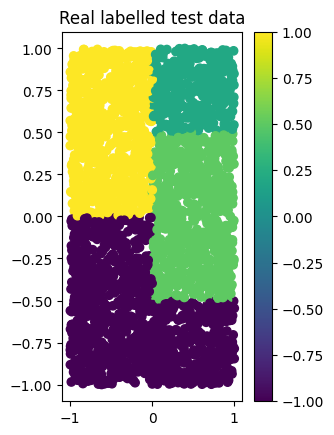

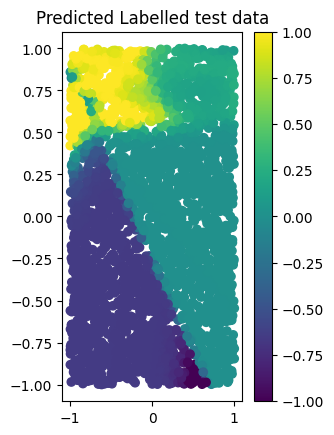

<ipython-input-35-54b9ed8c1936>:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(5,5))


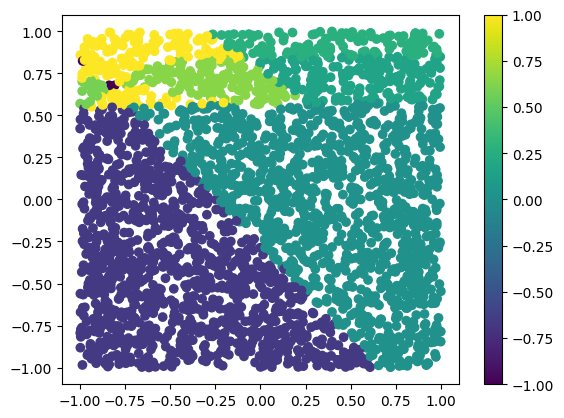

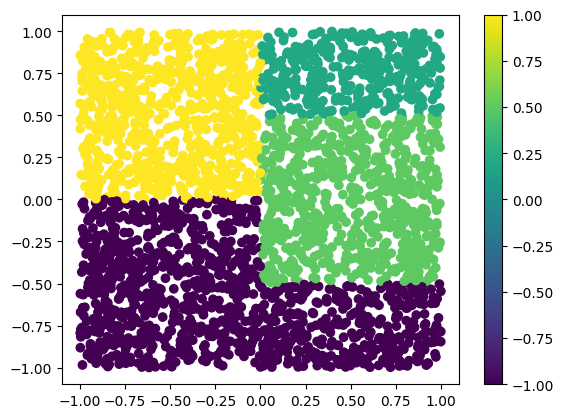

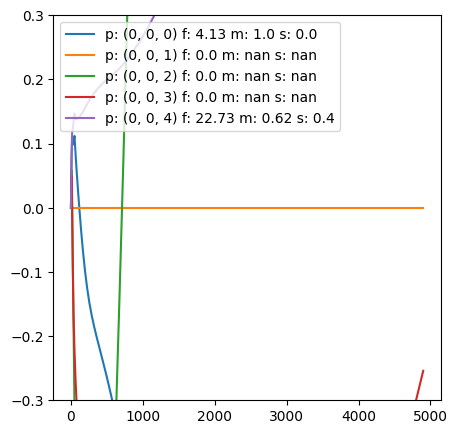

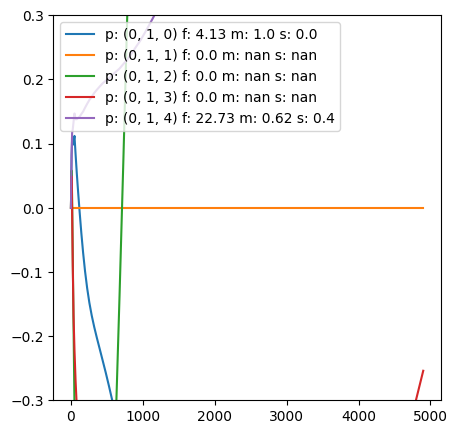

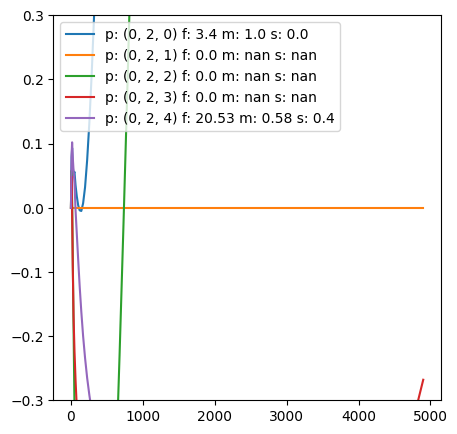

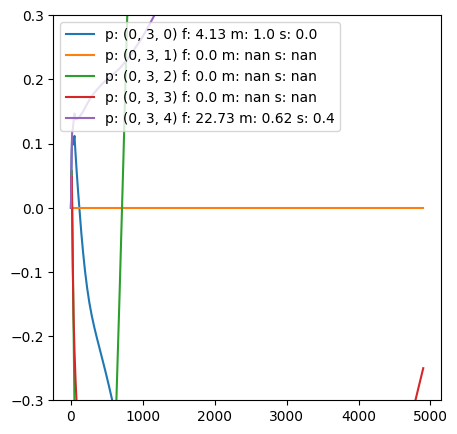

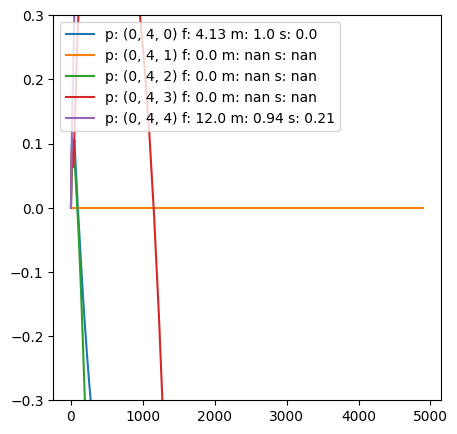

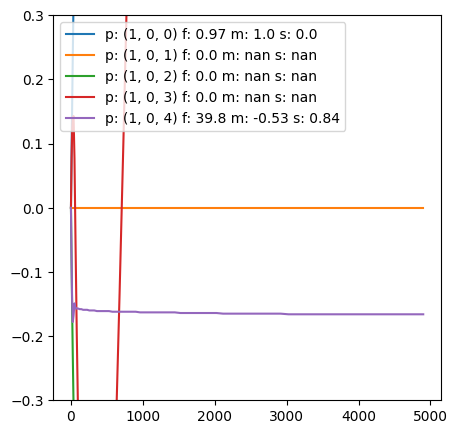

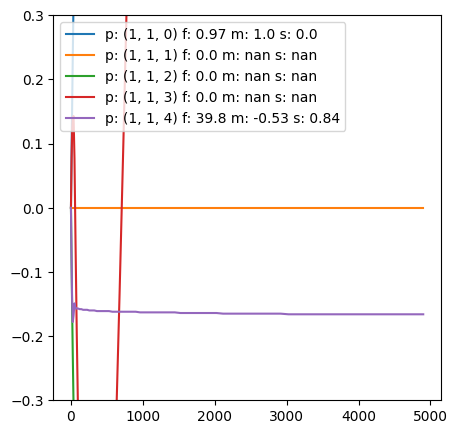

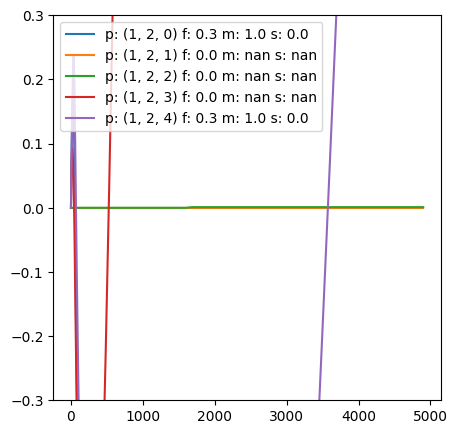

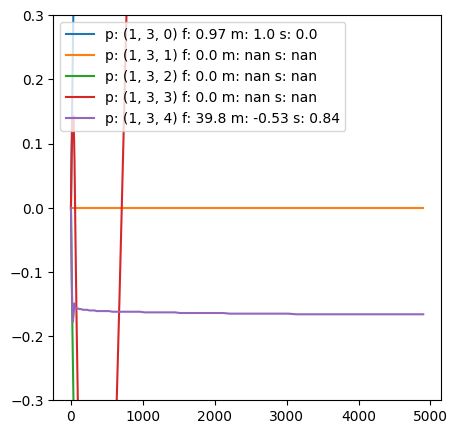

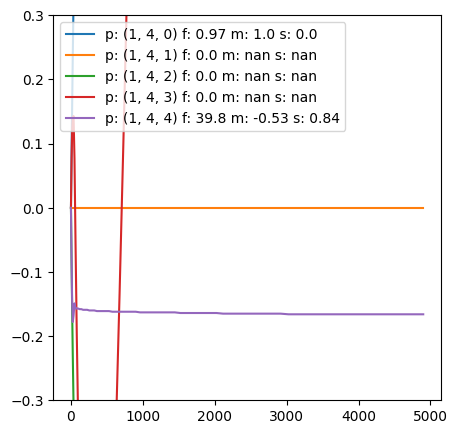

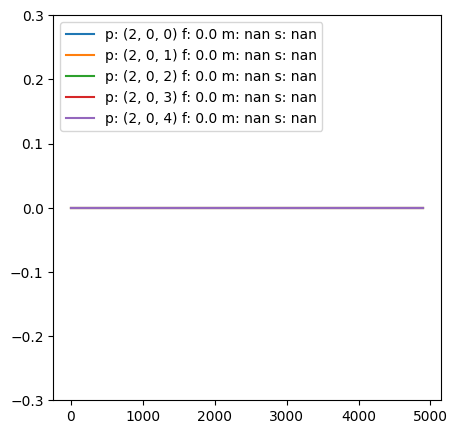

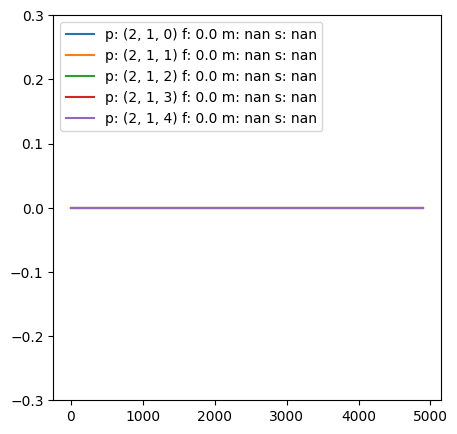

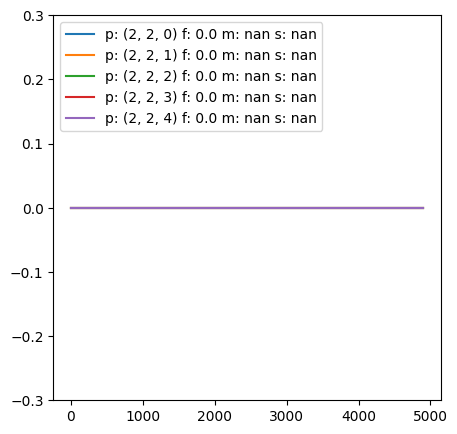

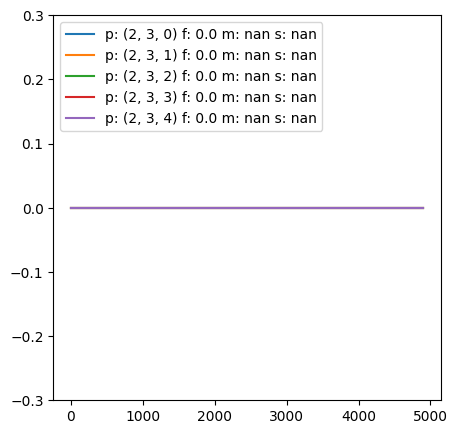

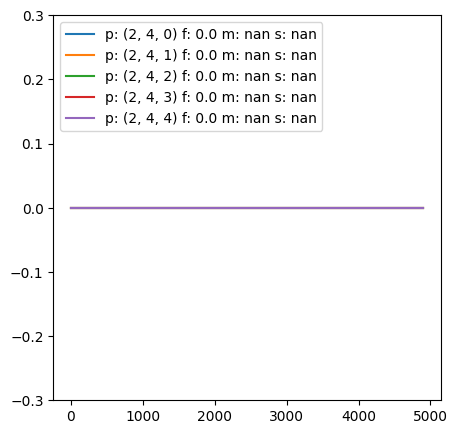

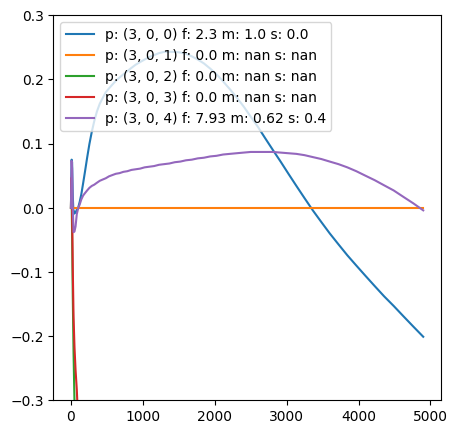

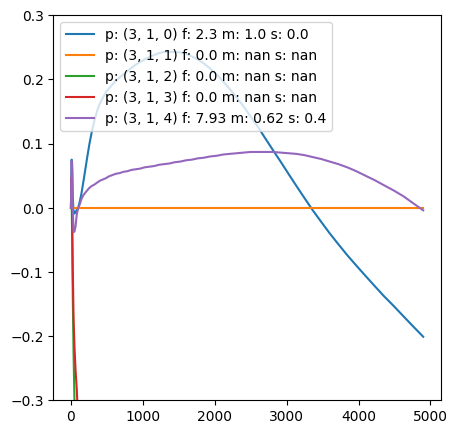

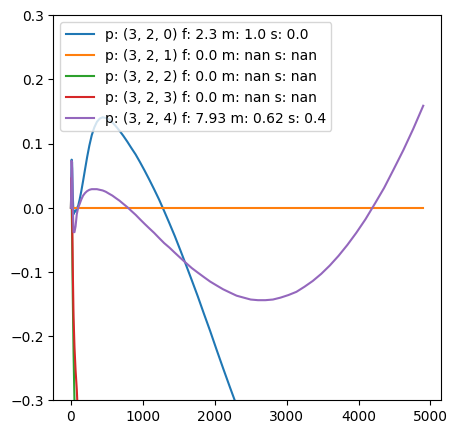

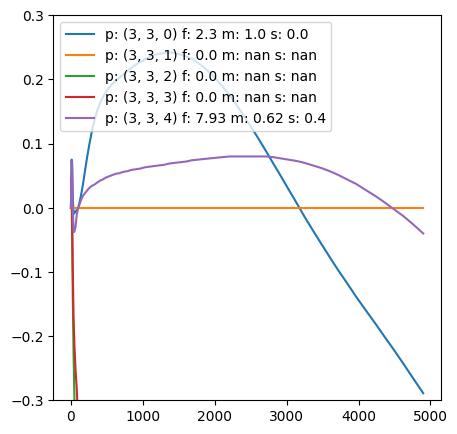

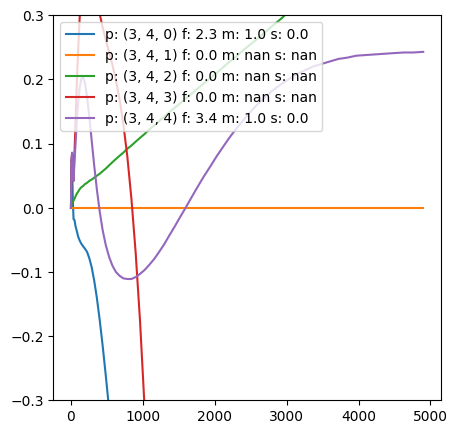

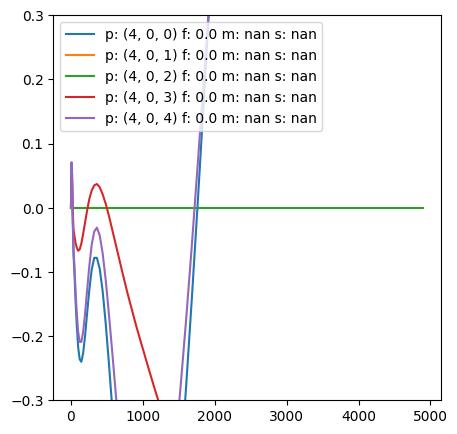

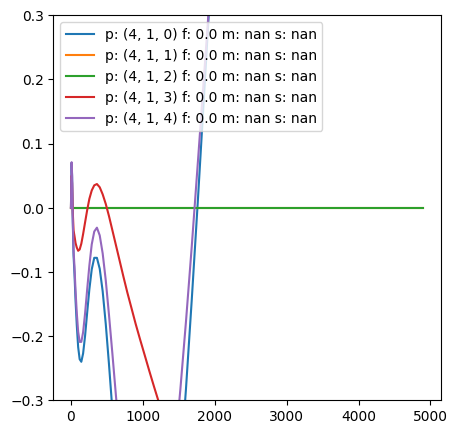

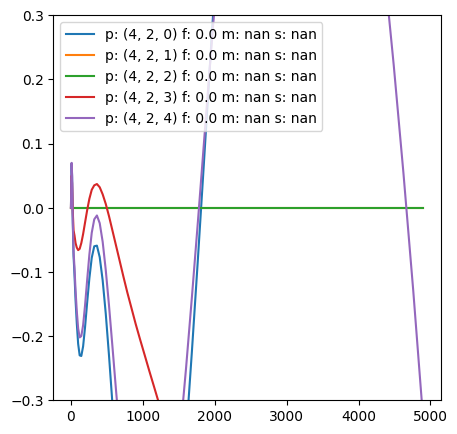

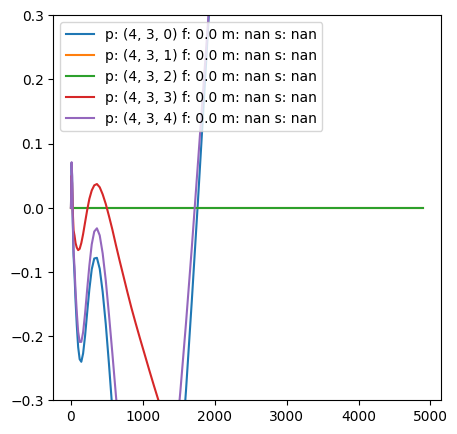

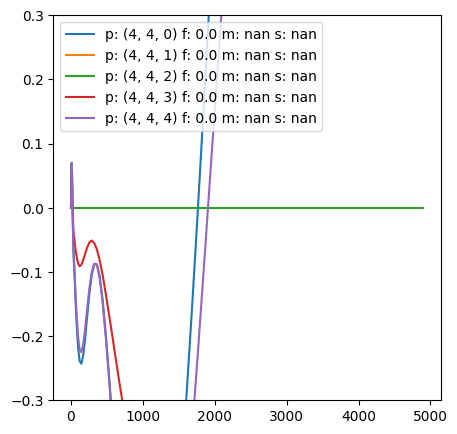

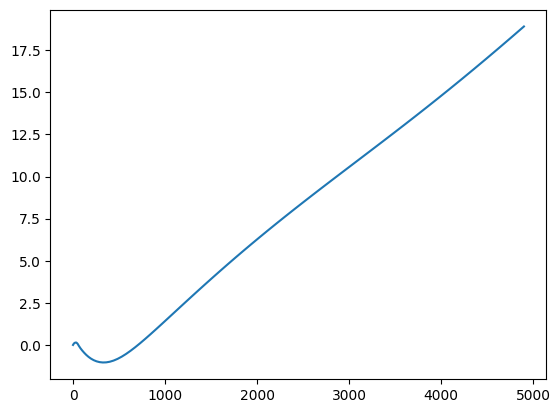

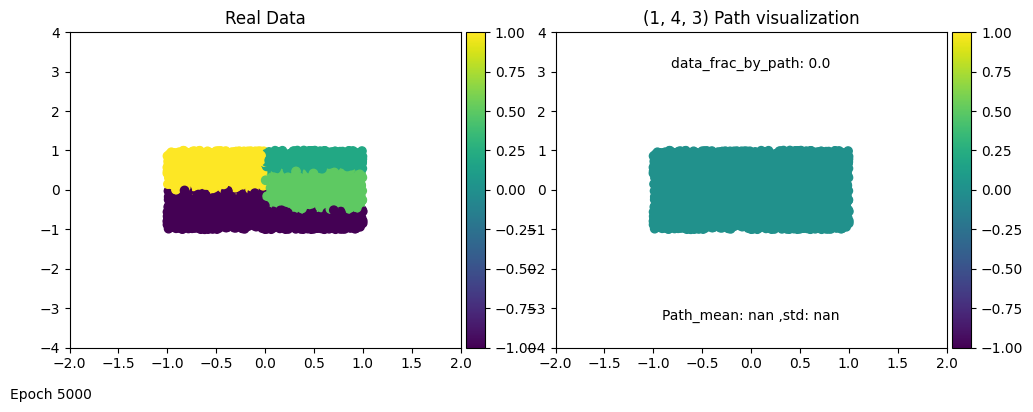

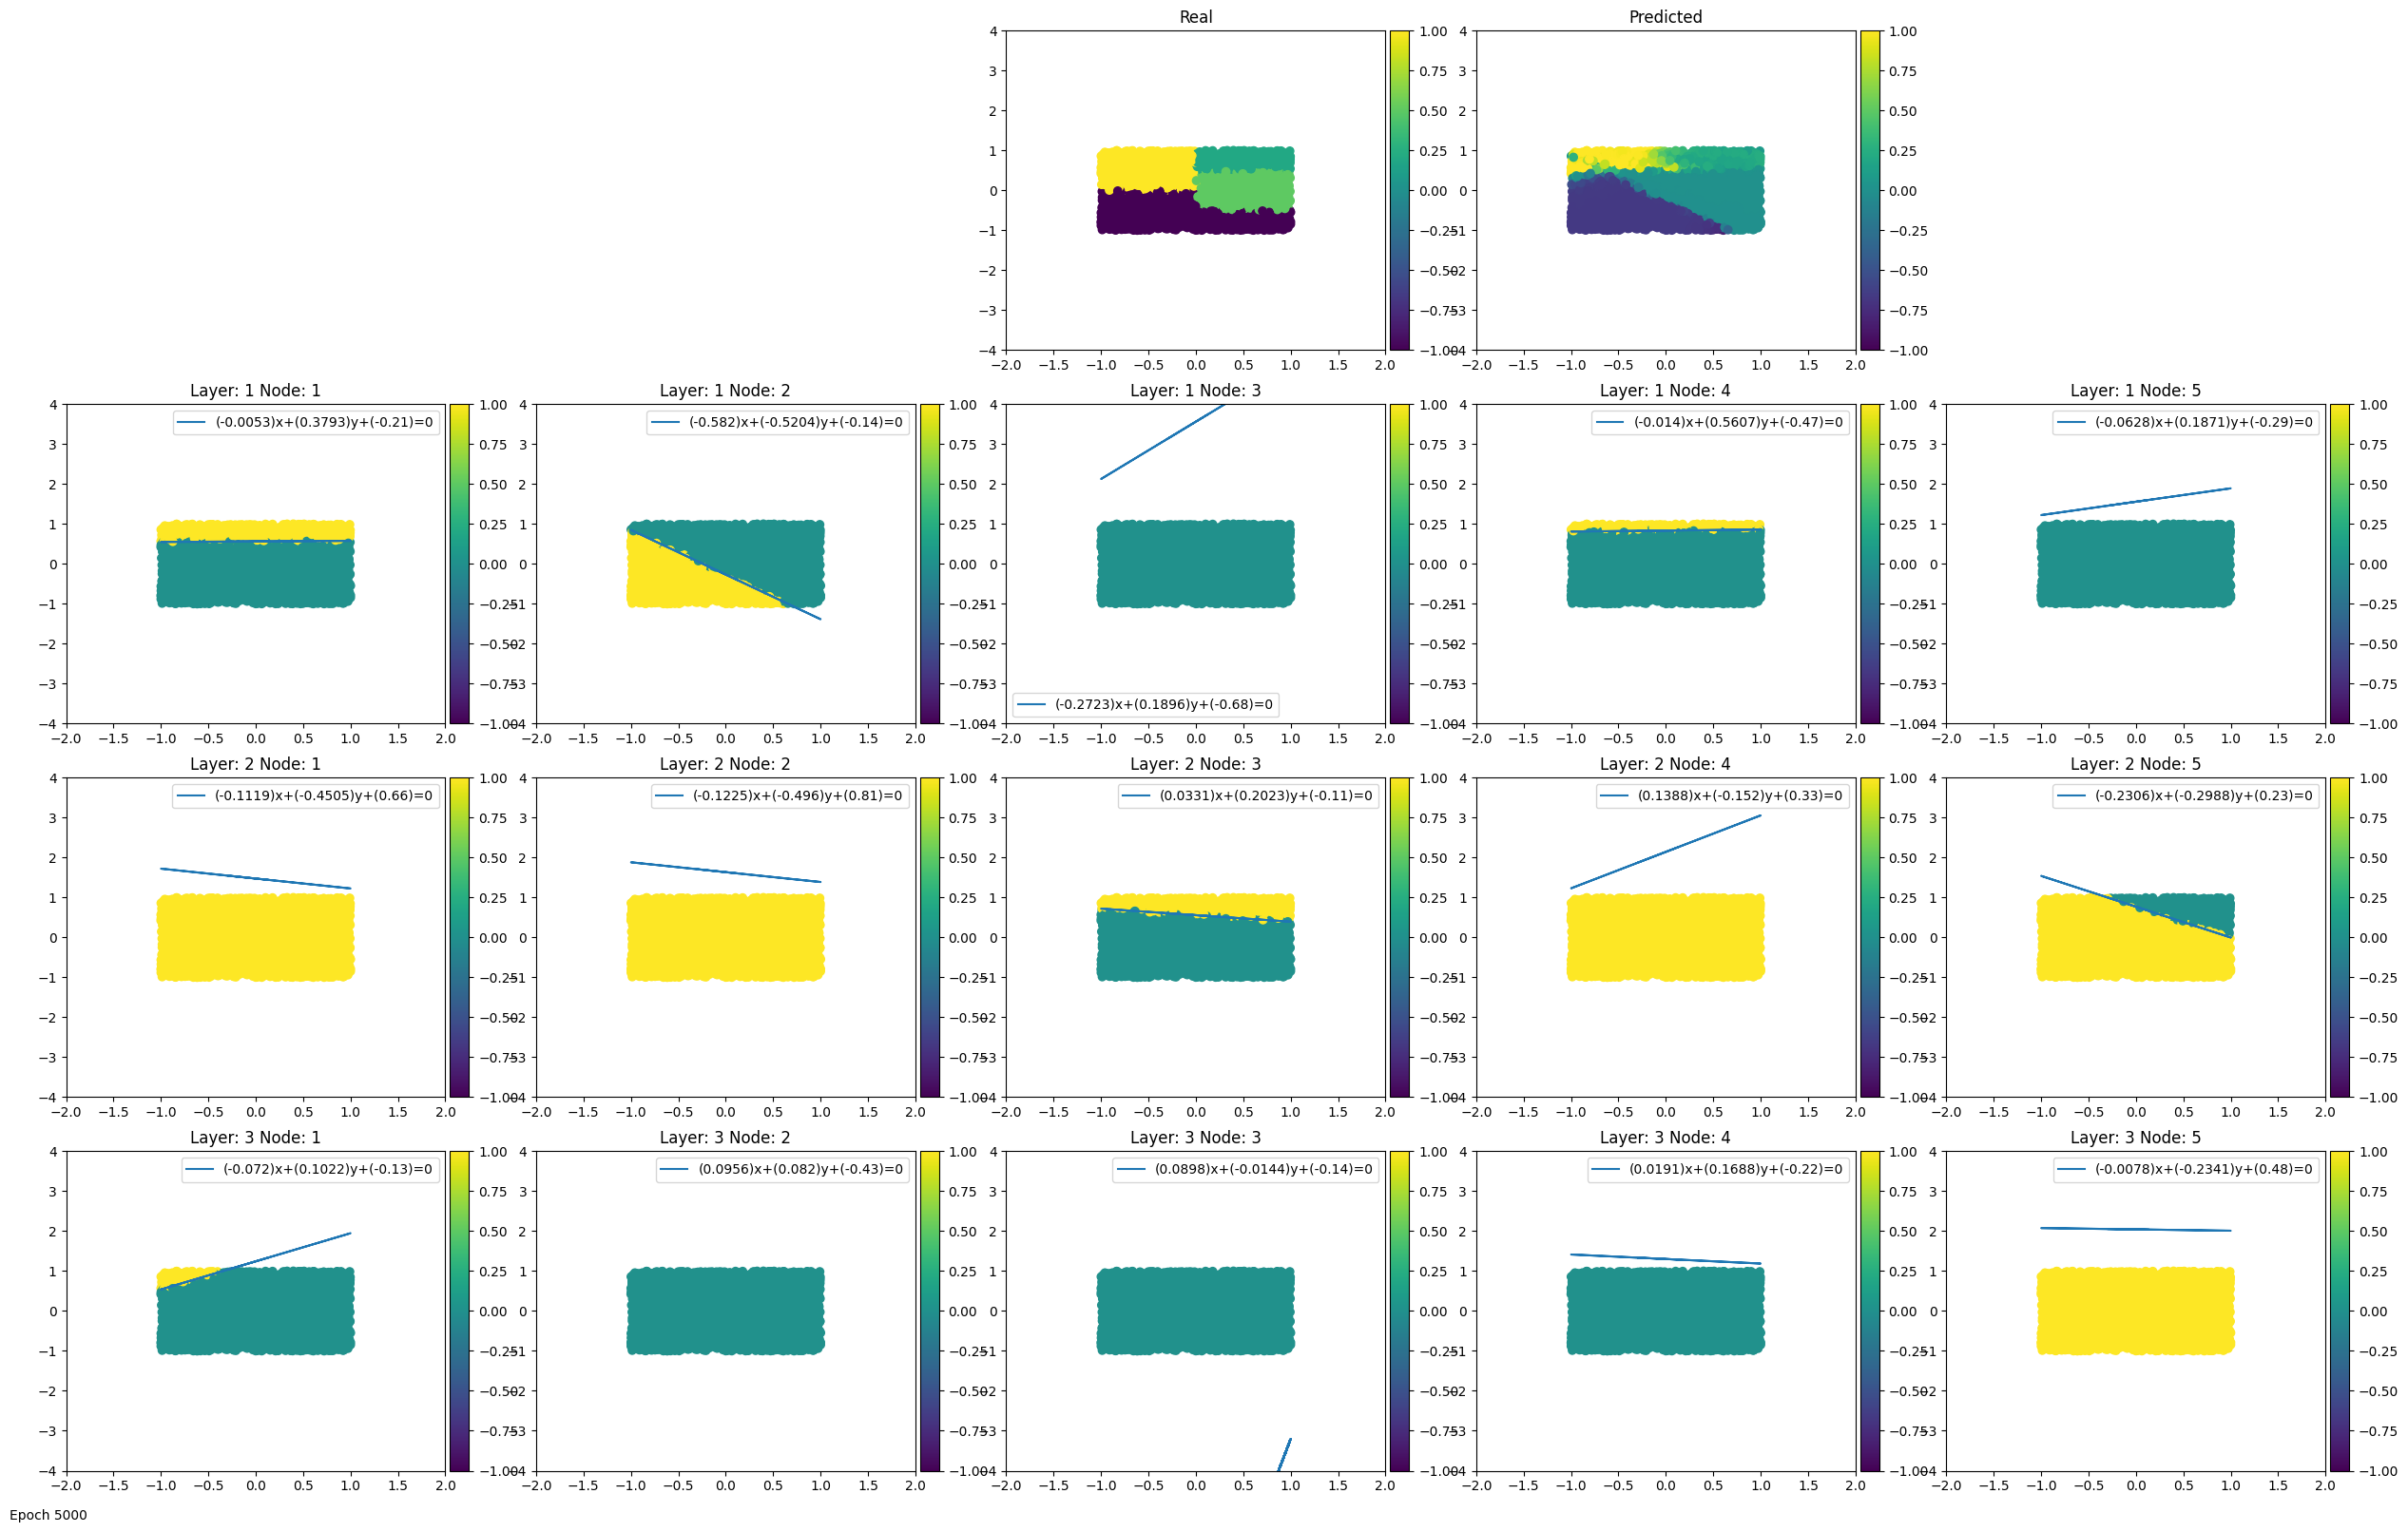

In [37]:
if infer_model: #if we have similar kind of paths only one of them vary much rest don't vary that much (2,1/2,0/3) (1,4,0/1/3/4) #seed 365
  if infer_path_lr:
    enter_path = (1,4,3) #(2,2,3)#(2,1,0)#(2,1,3)#(1,4,0)#(1,4,3)#(1,4,1)#(1,4,4) #(2,0,3) #(2,2,0)  
    plot_epoch = 5000
    enter_epoch = 5000
    weight_model_type = "Path_LR"
    data_pred_scatter_plot(predictions_lr)
    check_sanity(weight_model_type,enter_epoch)
    _,path_val=print_any_path(plot_epoch,weight_model_type,find_path=enter_path)
    plot_all_paths(plot_epoch,weight_model_type)
    #**Path visualization of one path**
    plot_path_value_variation(enter_path,plot_epoch,weight_model_type)
    show_path_hyp(enter_path,enter_epoch,weight_model_type)
    #**All node visualization**
    show_node_hyp(enter_epoch,weight_model_type)

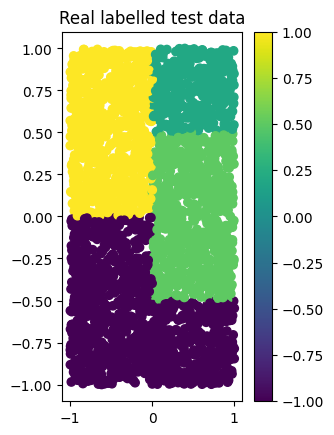

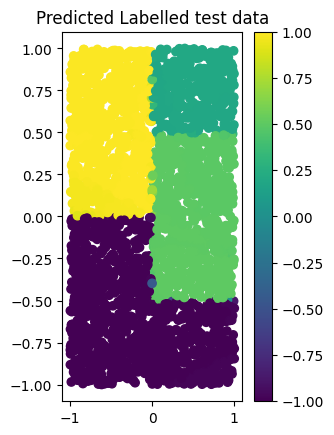

<ipython-input-35-54b9ed8c1936>:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(5,5))


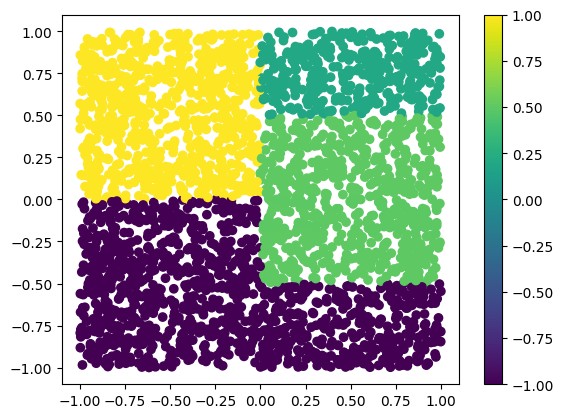

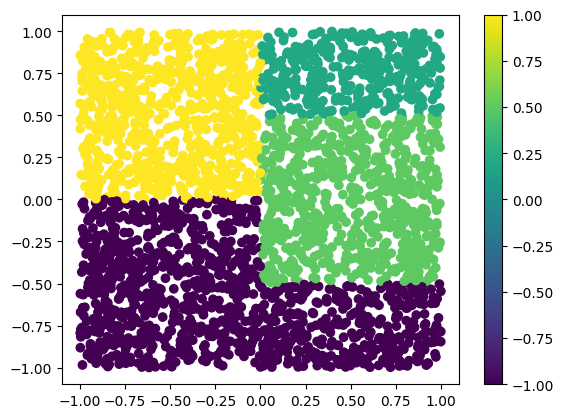

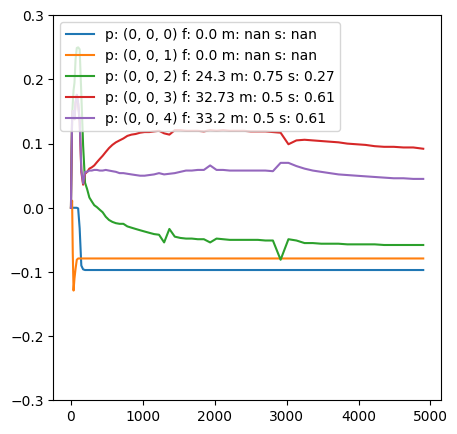

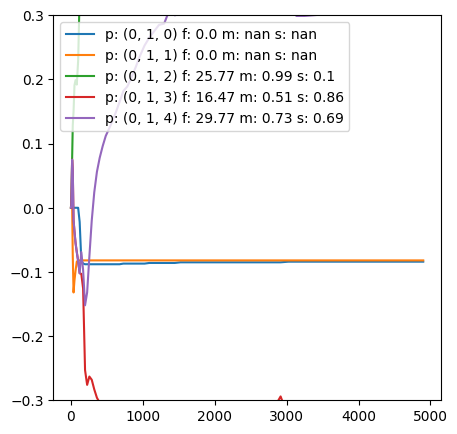

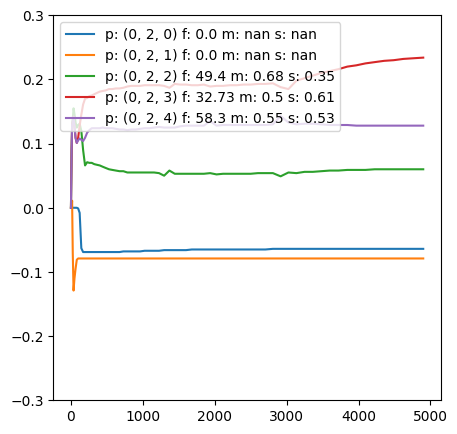

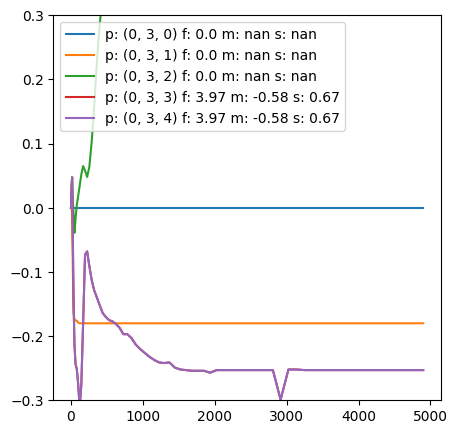

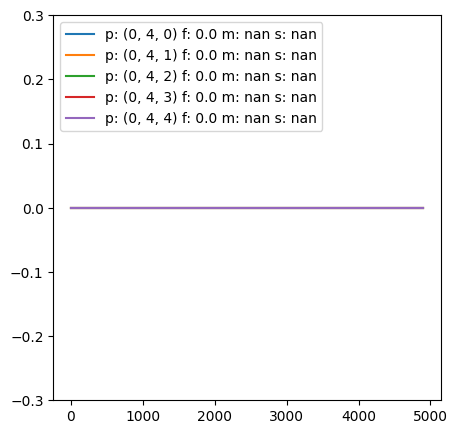

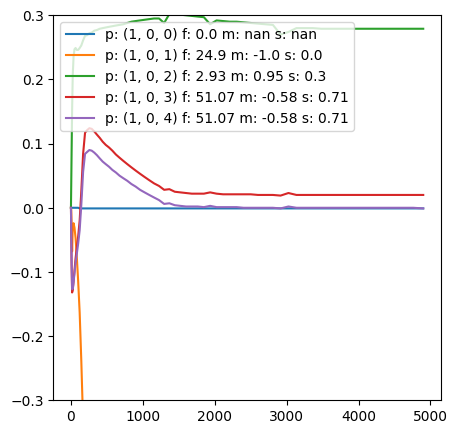

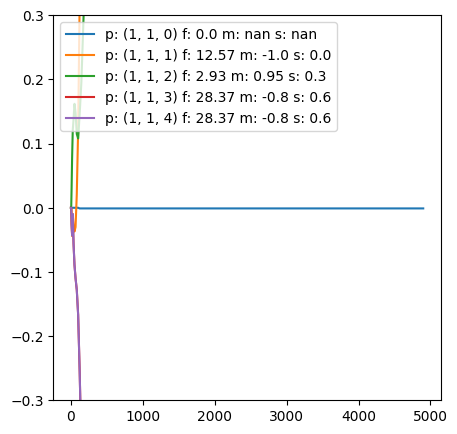

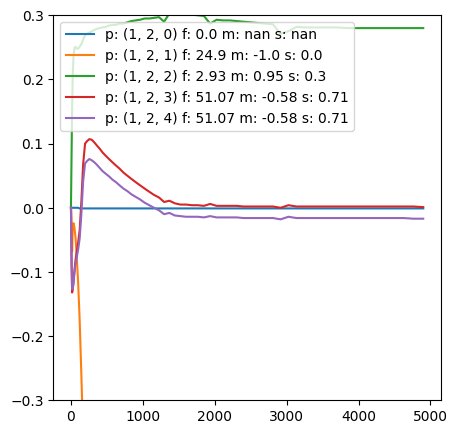

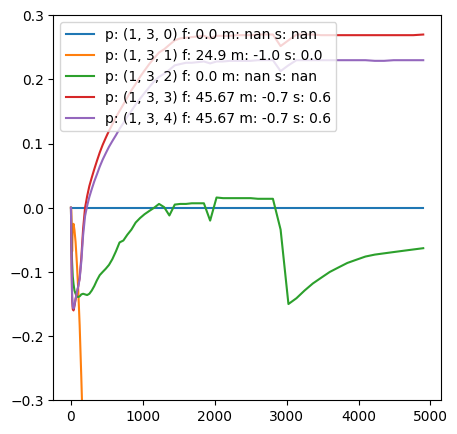

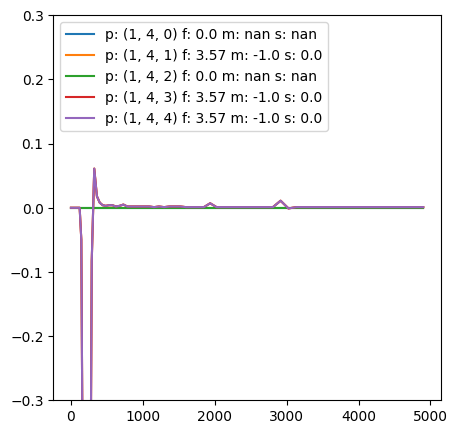

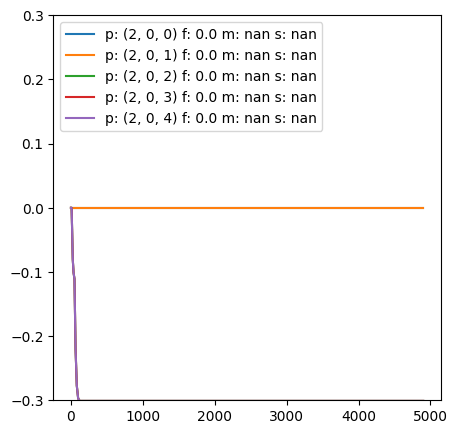

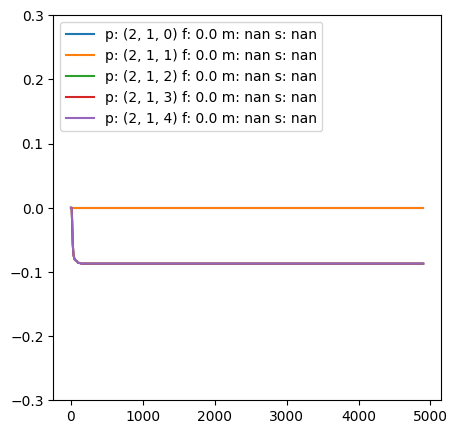

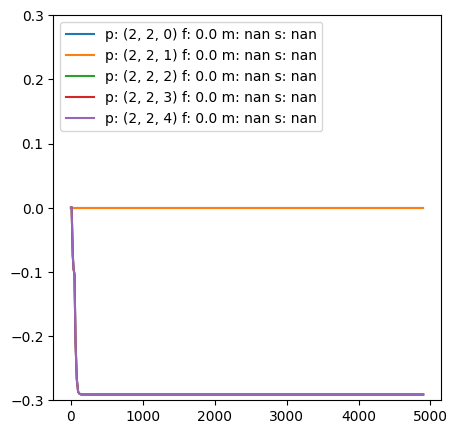

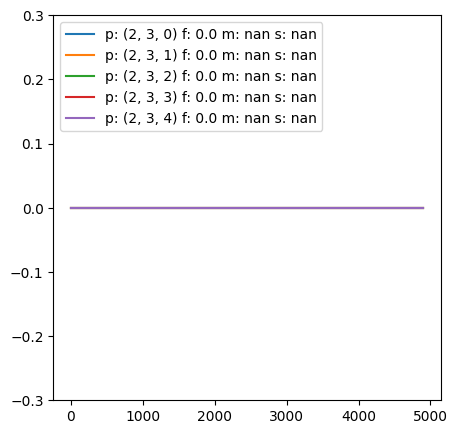

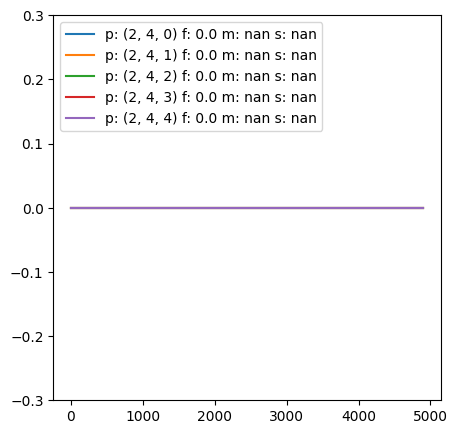

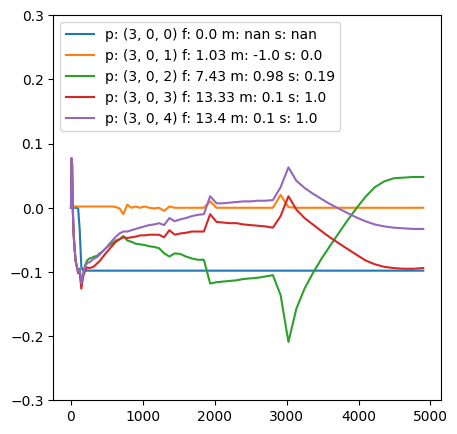

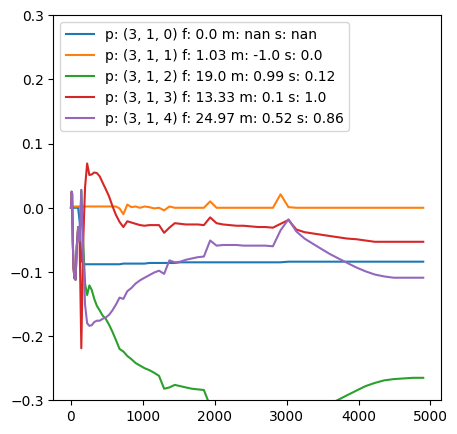

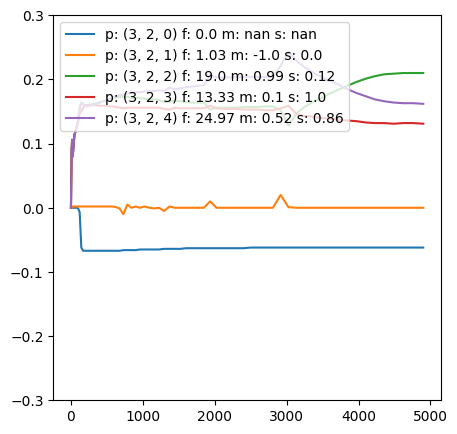

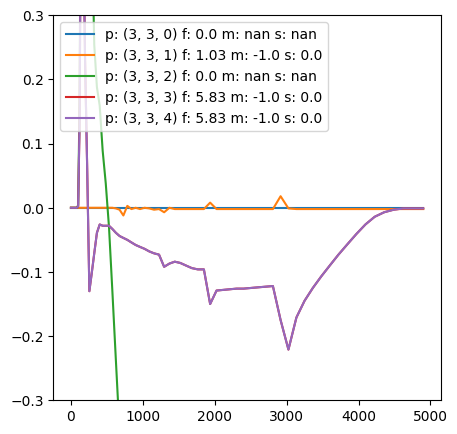

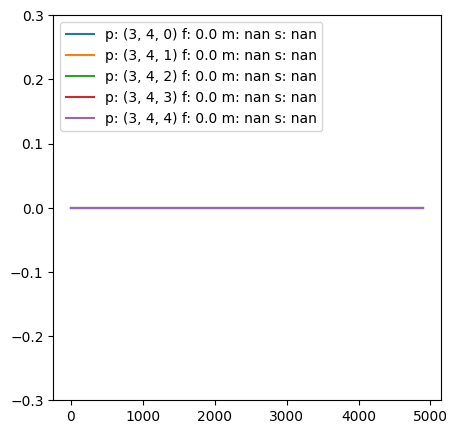

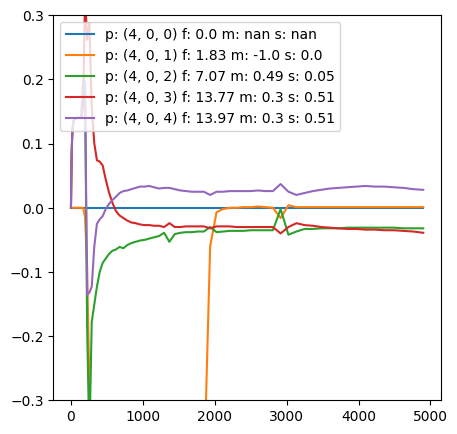

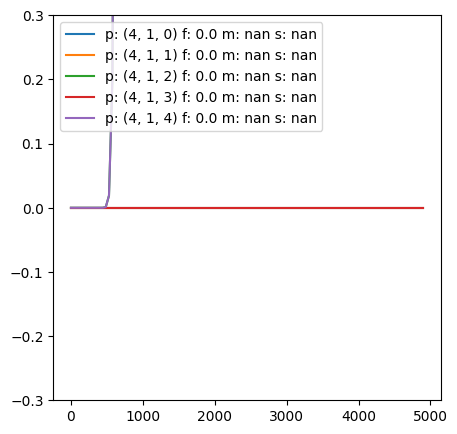

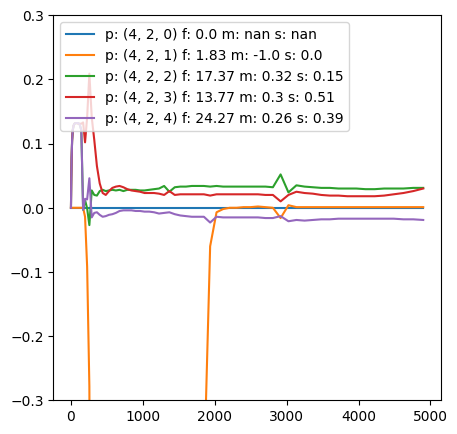

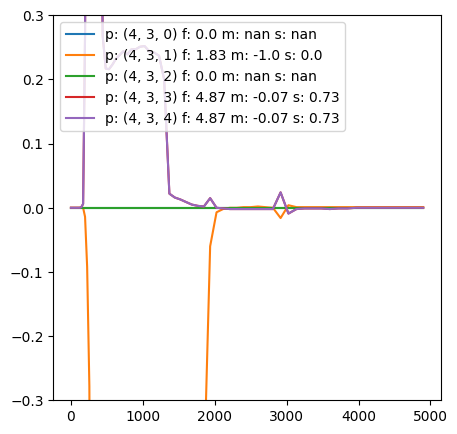

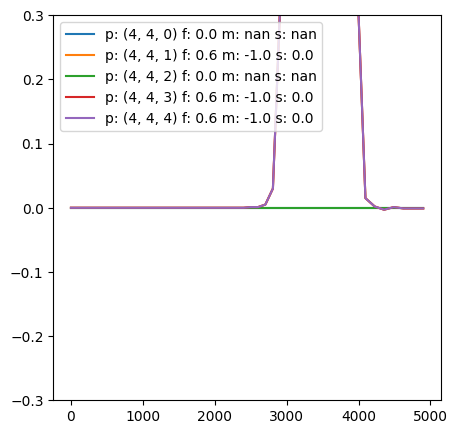

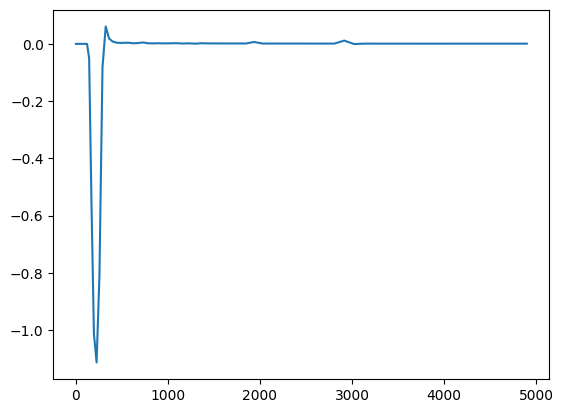

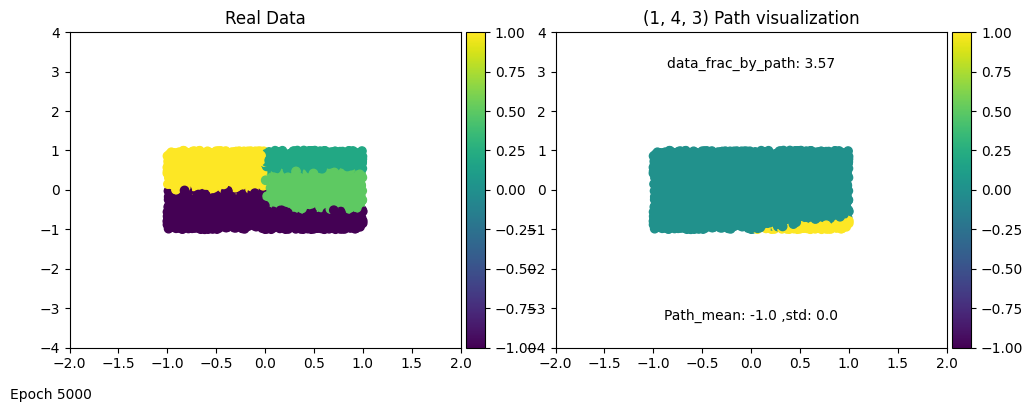

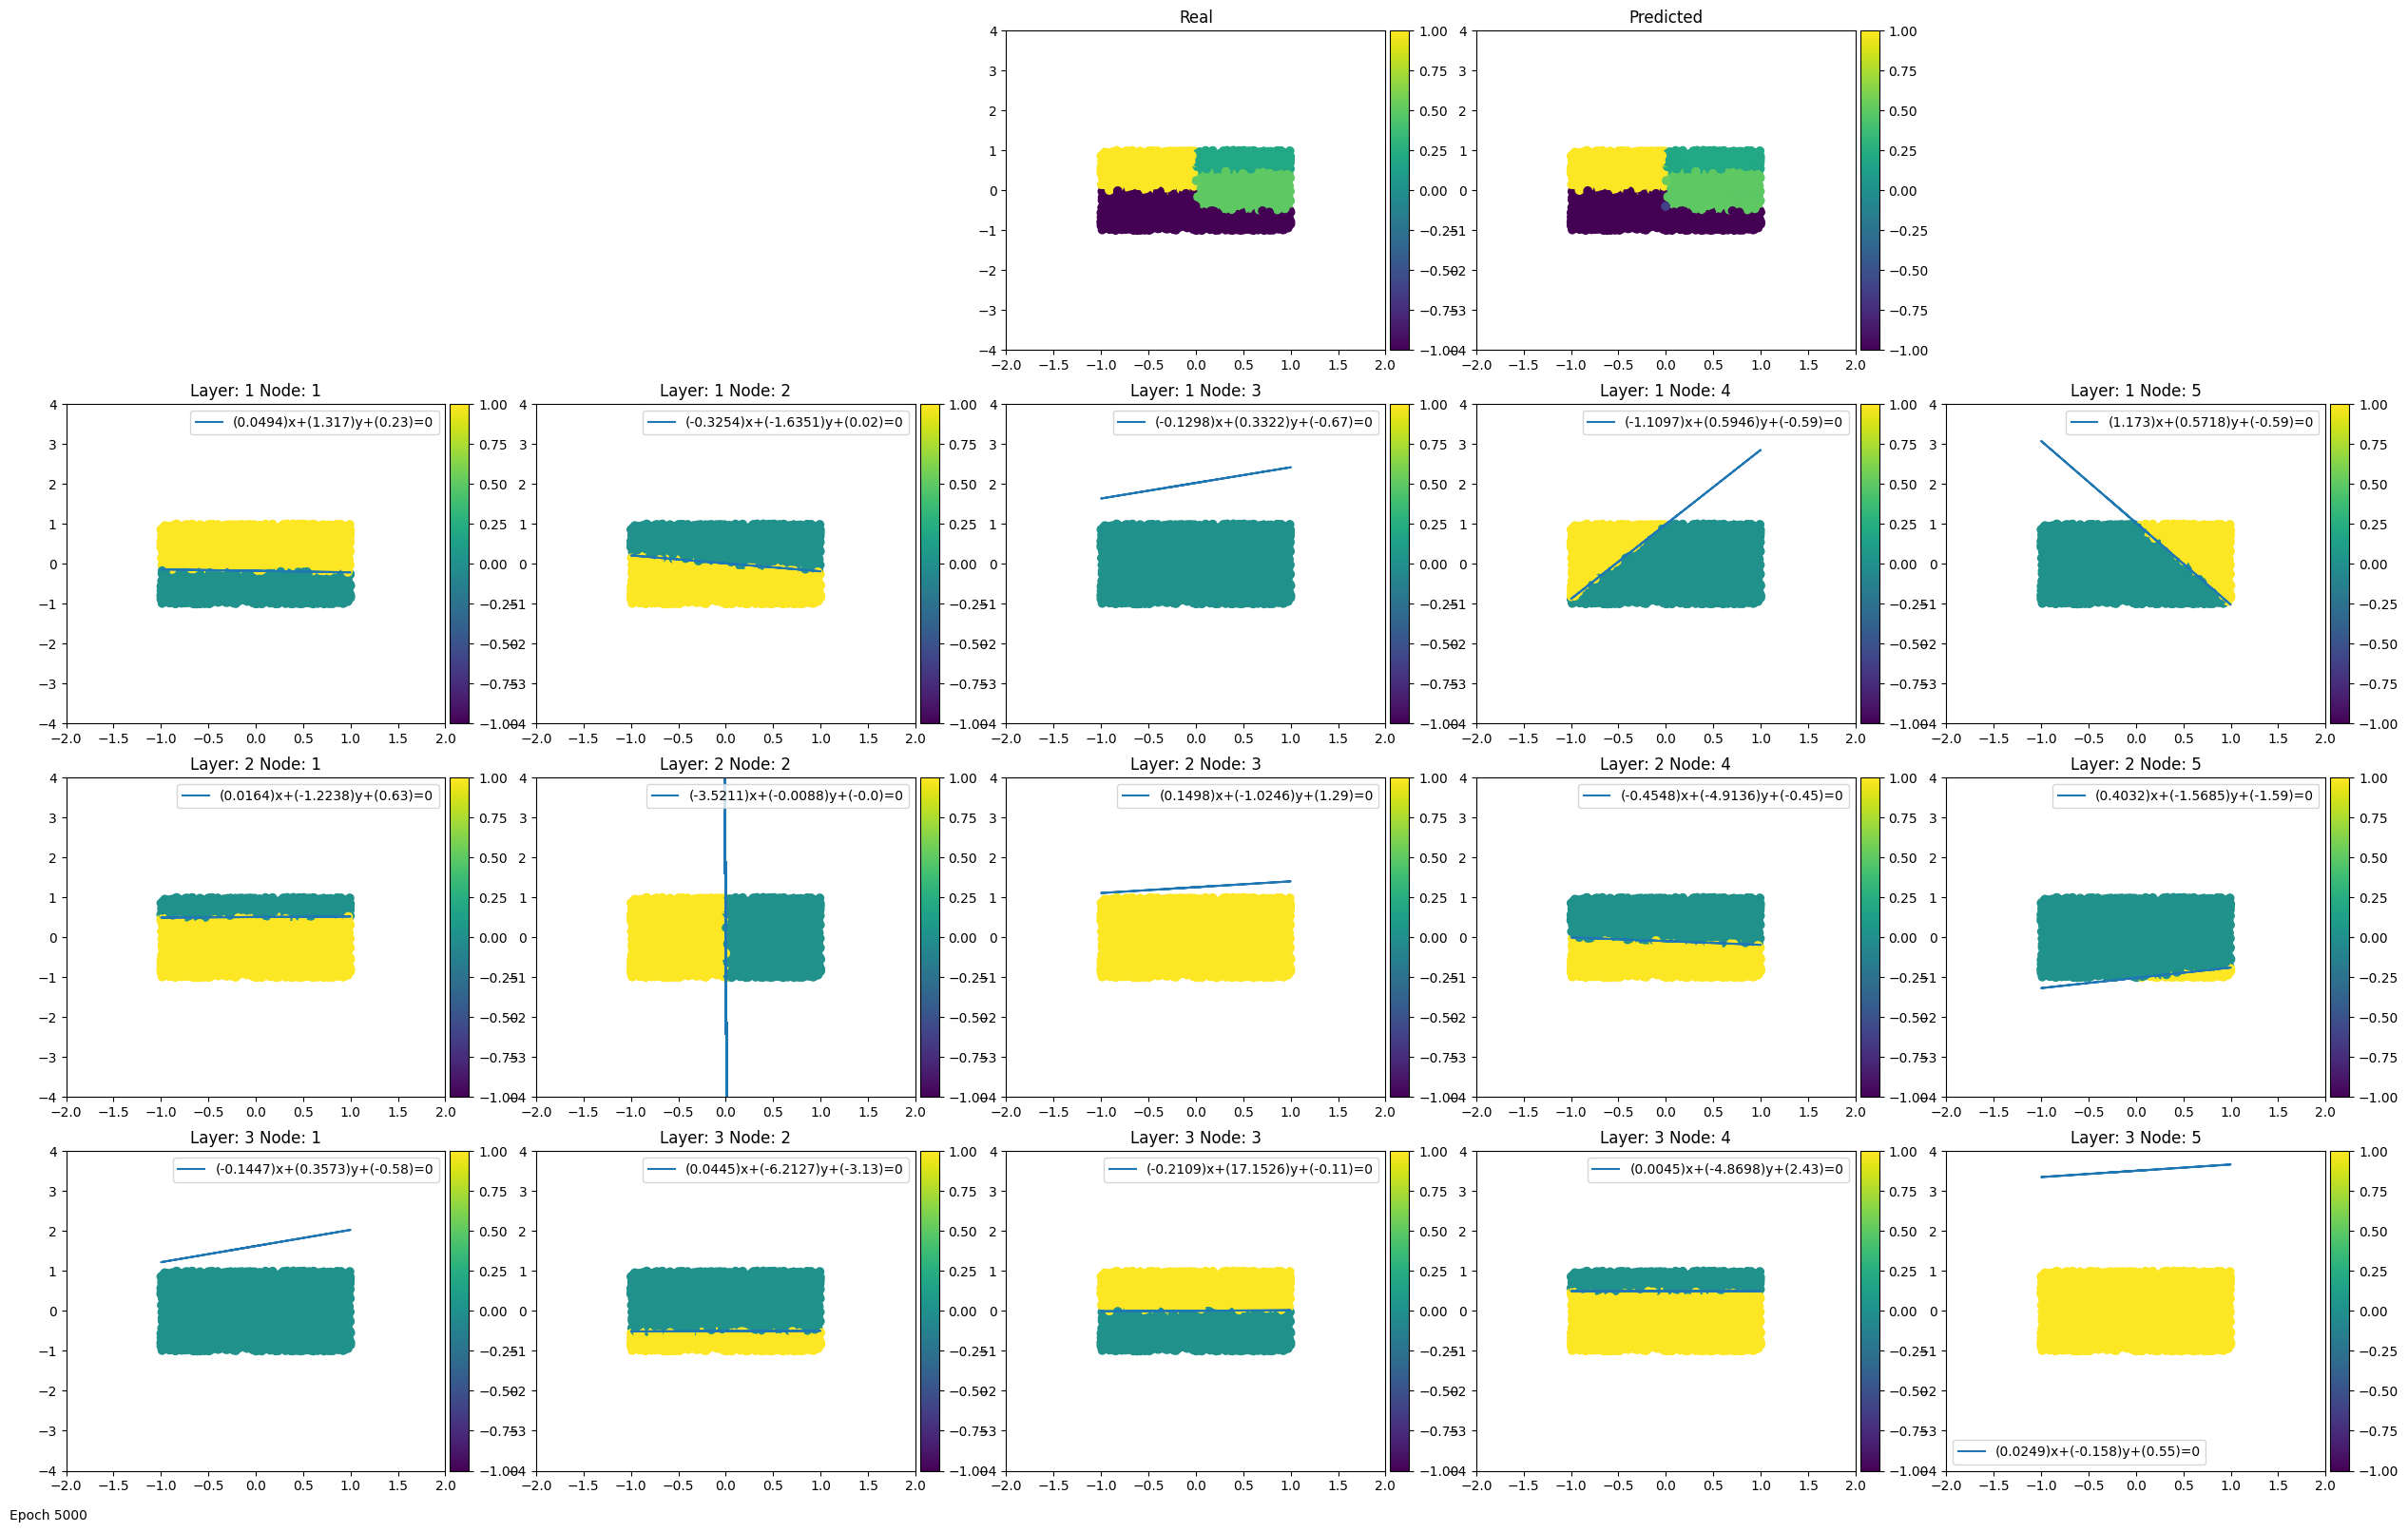

In [38]:
if infer_dlgn_lr:
  enter_path = (1,4,3) #(2,2,3)#(2,1,0)#(2,1,3)#(1,4,0)#(1,4,3)#(1,4,1)#(1,4,4) #(2,0,3) #(2,2,0)  
  plot_epoch = 5000
  enter_epoch = 5000
  weight_model_type = "DLGN_LR"
  data_pred_scatter_plot(predictions_dlgn_lr)
  check_sanity(weight_model_type,enter_epoch)
  _,path_val=print_any_path(plot_epoch,weight_model_type,find_path=enter_path)
  plot_all_paths(plot_epoch,weight_model_type)
  #**Path visualization of one path**
  plot_path_value_variation(enter_path,plot_epoch,weight_model_type)
  show_path_hyp(enter_path,enter_epoch,weight_model_type)
  #**All node visualization**
  show_node_hyp(enter_epoch,weight_model_type)

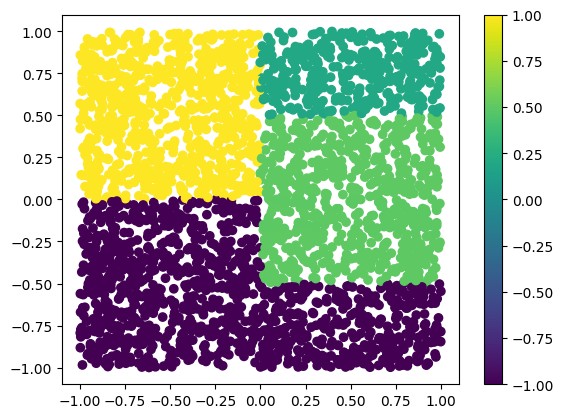

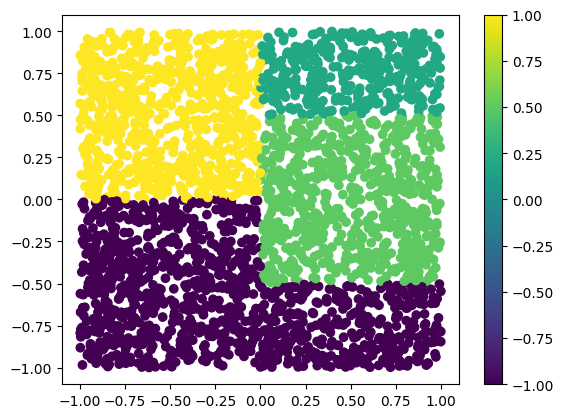

In [39]:
if infer_dlgn_lr:
  check_sanity("DLGN_LR",5000)

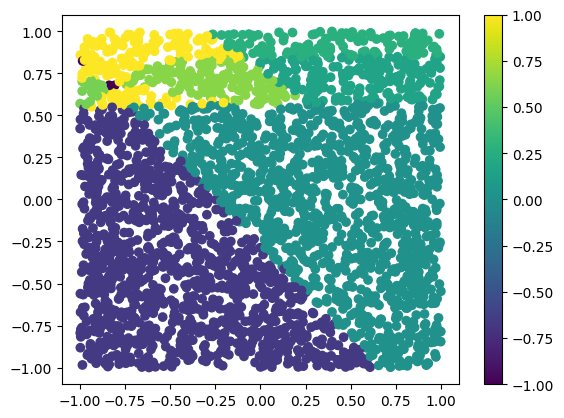

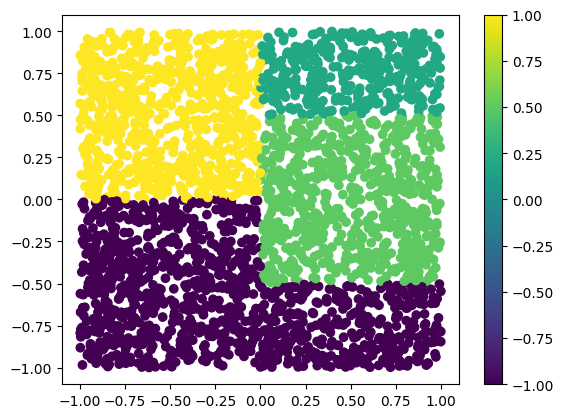

In [40]:
if infer_path_lr:
  check_sanity("Path_LR",5000)

In [41]:
#@title **Losswise comparision of DLGN and LR models**
def find_nearest_idx(array, value):
  idx = (np.abs(array - value)).argmin()
  return idx
def loss_wise_comp():
  X=test_data_curr[:,0]
  Y=test_data_curr[:,1]
  loss_check =[1,0.7,0.6,0.5,0.4,0.3,0.2,0.1,0.05,0.01,0.001,0]

  test_data_torch_dlgn = torch.Tensor(test_data_curr)
  test_data_torch_lr = torch.Tensor(path_fea_test) 


  no_rows=len(loss_check)+1
  no_colns = 2
  fig,ax=plt.subplots(no_rows,no_colns,figsize=(5*no_colns,4*no_rows)) 
  fig.tight_layout(pad=5)
  fig.text(0,0,s="DLGN vs LR")
  im_hide = ax[0,0].axis('off')
  
  im0=ax[0,1].scatter(X, Y, c=test_labels_curr,vmin=-1,vmax=1)
  ax[0,1].title.set_text("Real")
  ax[0,1].set_xlim(-2,2)
  ax[0,1].set_ylim(-2,2)
  divider = make_axes_locatable(ax[0,1])
  cax = divider.append_axes('right', size='5%', pad=0.05)
  fig.colorbar(im0, cax=cax, orientation='vertical')
  

  for index,loss_val in enumerate(loss_check):  
    enter_epoch_dlgn = find_nearest_idx(losses,loss_val)
    enter_epoch_lr = find_nearest_idx(losses_lr,loss_val) 

    dlgn_index=int(np.sqrt(enter_epoch_dlgn))
    DLGN_obj = DLGN_obj_store[dlgn_index]
    values,gate_scores =DLGN_obj(test_data_torch_dlgn)
    path_values_dlgn = values[-1]

    if model_type == "Classification":
      test_preds_dlgn = torch.cat((-1*path_values_dlgn,path_values_dlgn),dim=1)
      predictions_dlgn = torch.argmax(test_preds_dlgn,dim=1).numpy()
    if model_type == "Regression":
      test_preds_dlgn = path_values_dlgn
      predictions_dlgn=test_preds_dlgn.detach().numpy()

    lr_index=int(np.sqrt(enter_epoch_lr))
    Path_LR_obj = Path_LR_obj_store[lr_index]
    path_values_lr = Path_LR_obj(test_data_torch_lr)

    if model_type == "Classification":
      test_preds_lr = torch.cat((-1*path_values_lr,path_values_lr),dim=1)
      predictions_lr = torch.argmax(test_preds_lr,dim=1).numpy()
    if model_type == "Regression":
      test_preds_lr = path_values_lr
      predictions_lr=test_preds_lr.detach().numpy()

   
      im=ax[index+1,0].scatter(X, Y, c=predictions_dlgn,vmin=-1,vmax=1)
      ax[index+1,0].set_xlim(-2,2)
      ax[index+1,0].set_ylim(-2,2)
      # ax[index+1,0].title.set_text("Loss : "+str(round(losses[enter_epoch_dlgn],4))+" , "+str(round(losses[dlgn_index*dlgn_index],4))+" Epoch : "+str(enter_epoch_dlgn)+" , "+str(dlgn_index*dlgn_index)+" DLGN")
      ax[index+1,0].title.set_text("Loss : "+str(round(losses[dlgn_index*dlgn_index],4))+" Epoch : "+str(dlgn_index*dlgn_index)+" DLGN")
      # ax[index+1,0].legend()
      divider = make_axes_locatable(ax[index+1,0])
      cax = divider.append_axes('right', size='5%', pad=0.05)
      fig.colorbar(im, cax=cax, orientation='vertical')

      im1=ax[index+1,1].scatter(X, Y, c=predictions_lr,vmin=-1,vmax=1)
      ax[index+1,1].set_xlim(-2,2)
      ax[index+1,1].set_ylim(-2,2)
      # ax[index+1,1].title.set_text("Loss : "+str(round(losses_lr[enter_epoch_lr],4))+" , "+str(round(losses_lr[lr_index*lr_index],4))+" Epoch : "+str(enter_epoch_lr)+" , "+str(lr_index*lr_index)+" LR")
      ax[index+1,1].title.set_text("Loss : "+str(round(losses_lr[lr_index*lr_index],4))+" Epoch : "+str(lr_index*lr_index)+" LR")
      # ax[index+1,1].legend()
      divider = make_axes_locatable(ax[index+1,1])
      cax = divider.append_axes('right', size='5%', pad=0.05)
      fig.colorbar(im, cax=cax, orientation='vertical')
    

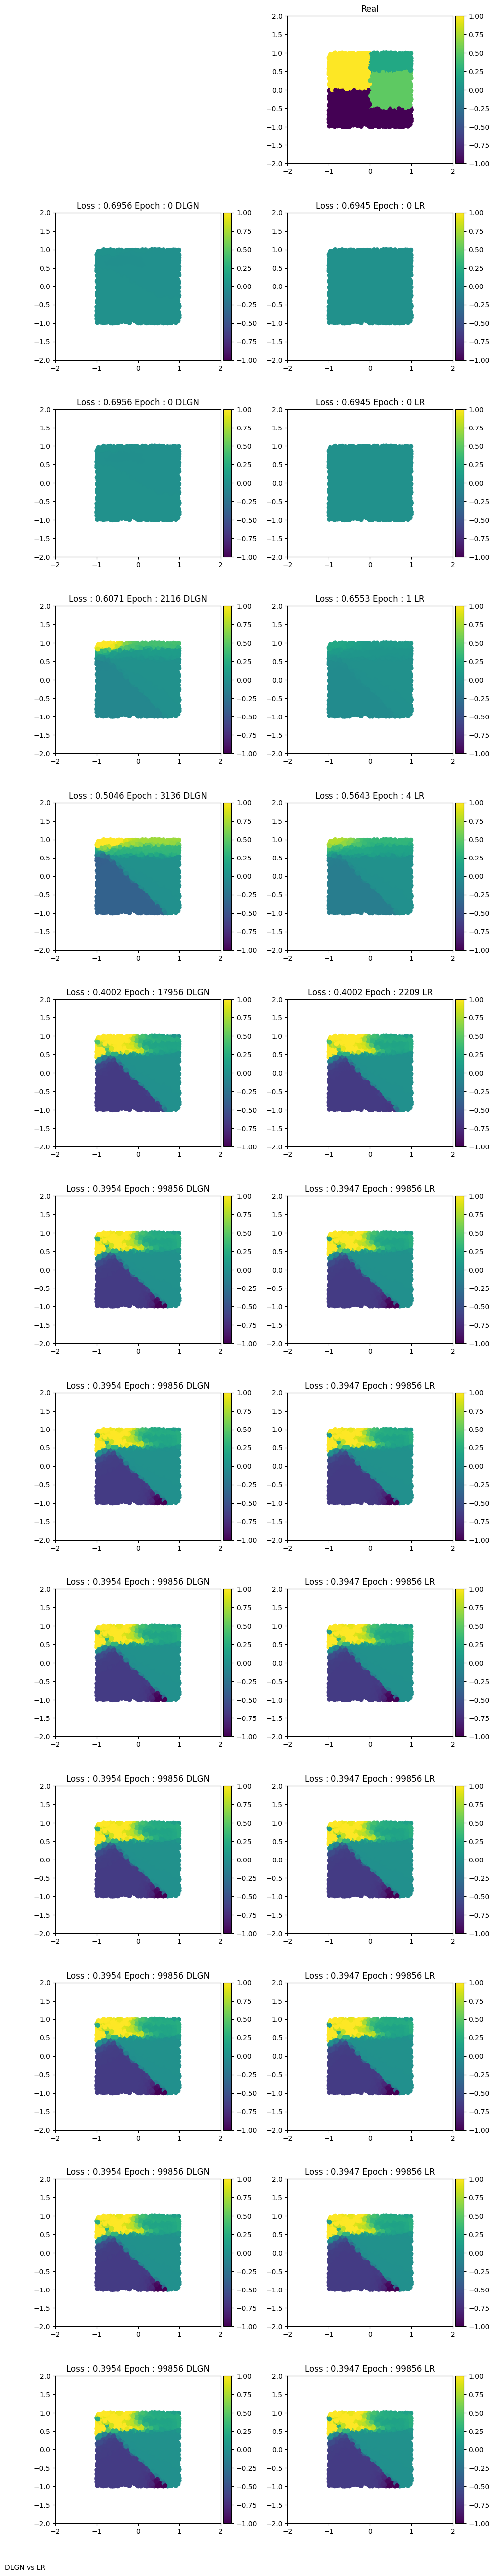

In [42]:
if infer_model:
  loss_wise_comp()